In [12]:
# Clone PatchTST repository and set it as working directory
import os

# Change to the repository directory
os.chdir('/content/PatchTST')
print(f"Current directory: {os.getcwd()}")

Current directory: /content/PatchTST


## 1. Setup and Installation <a id='setup'></a>

First, let's import necessary libraries and set up the environment.

In [13]:
import sys
import os

# Add PatchTST_supervised to path
sys.path.append('/content/PatchTST/PatchTST_supervised')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Understanding Physics-Based Variable-Length PatchTST <a id='architecture'></a>

### Key Insight: Integrating Hour-of-Day with Physics

Instead of keeping hour features in a separate group, we **integrate hour_sin and hour_cos into each physics group** that has strong diurnal dependence. This allows each encoder to directly learn the relationship between time-of-day and its physics variables.

**Why integrate hour features?**
- **Thermodynamics**: Temperature is directly driven by solar cycle → hour is critical
- **Moisture**: Evaporation peaks during day, condensation at night → hour helps
- **Precipitation**: Convective storms often peak in afternoon → hour helps
- **Atmospheric Dynamics**: Pressure/wind have weaker diurnal signal → hour helps less but still useful

### Physics-Based Groups with Integrated Hour Features (4 groups, 23 channels):

| Group | Physics Variables | Hour Features | Total Ch | Patch Length |
|-------|------------------|---------------|----------|--------------|
| **Thermodynamics** | 8 temp/radiation vars | hour_sin, hour_cos | **10** | 48 steps (8h) |
| **Moisture** | 7 humidity/vapor vars | hour_sin, hour_cos | **9** | 32 steps (5.3h) |
| **Precipitation** | 2 rain vars | hour_sin, hour_cos | **4** | 12 steps (2h) |
| **Atmospheric Dynamics** | 4 pressure/wind vars | (none - weaker diurnal) | **4** | 24 steps (4h) |

**Note**: Hour features are processed with the same patch length as their physics group, allowing the model to learn time-physics correlations at the appropriate temporal resolution.

### Architecture Components:
1. **Data Preprocessing**: Add hour_sin and hour_cos to dataset (21 → 23 channels)
2. **RevIN**: Per-channel normalization
3. **Physics-Based Grouping**: Hour features integrated into diurnal-sensitive groups
4. **4 Channel-Independent Encoders**: Each learns hour-physics relationships
5. **Per-Channel Prediction Heads**: Individual heads per channel
6. **RevIN Denormalization**: Reverse normalization for output

In [14]:
# Change to PatchTST_supervised directory for imports
os.chdir('/content/PatchTST/PatchTST_supervised')
print(f"Changed to: {os.getcwd()}")

# Import PatchTST components
from models.PatchTST import Model as PatchTST
from layers.PatchTST_backbone import PatchTST_backbone, TSTiEncoder, Flatten_Head
from layers.PatchTST_layers import *
from layers.RevIN import RevIN

# Change back to root directory
os.chdir('..')
print(f"Back to: {os.getcwd()}")

# Visualize the Physics-Integrated Hour-of-Day Architecture
print("\n" + "=" * 70)
print("Physics-Integrated Hour-of-Day PatchTST Architecture")
print("=" * 70)
print("\n1. Input Time Series: [Batch, Seq_len, 23 Channels]")
print("   (21 weather + hour_sin + hour_cos)")
print("   ↓")
print("2. RevIN: Per-channel normalization")
print("   ↓")
print("3. Physics-Based Grouping WITH Integrated Hour Features:")
print("   ┌─────────────────────────────────────────────────────────────┐")
print("   │ THERMODYNAMICS (10 ch): T, Tpot, Tdew... + hour_sin/cos    │")
print("   │   → 48-step patches (diurnal: solar drives temperature)    │")
print("   ├─────────────────────────────────────────────────────────────┤")
print("   │ MOISTURE (9 ch): rh, VPmax, VPact... + hour_sin/cos        │")
print("   │   → 32-step patches (day evap / night condensation)        │")
print("   ├─────────────────────────────────────────────────────────────┤")
print("   │ PRECIPITATION (4 ch): rain, raining + hour_sin/cos         │")
print("   │   → 12-step patches (afternoon convective storms)          │")
print("   ├─────────────────────────────────────────────────────────────┤")
print("   │ ATMOSPHERIC DYNAMICS (4 ch): p, wv, max.wv, wd             │")
print("   │   → 24-step patches (synoptic, weaker diurnal signal)      │")
print("   └─────────────────────────────────────────────────────────────┘")
print("   ↓")
print("4. Per-Group Encoders: Each learns hour-physics correlations")
print("   ↓")
print("5. Per-Channel Prediction Heads (only weather channels output)")
print("   ↓")
print("6. Output: [Batch, Pred_len, 21 Weather Channels]")
print("=" * 70)
print("\nKey Insight: Hour features are processed WITH their physics group,")
print("allowing each encoder to learn time-dependent patterns directly.")

Changed to: /content/PatchTST/PatchTST_supervised
Back to: /content/PatchTST

Physics-Integrated Hour-of-Day PatchTST Architecture

1. Input Time Series: [Batch, Seq_len, 23 Channels]
   (21 weather + hour_sin + hour_cos)
   ↓
2. RevIN: Per-channel normalization
   ↓
3. Physics-Based Grouping WITH Integrated Hour Features:
   ┌─────────────────────────────────────────────────────────────┐
   │ THERMODYNAMICS (10 ch): T, Tpot, Tdew... + hour_sin/cos    │
   │   → 48-step patches (diurnal: solar drives temperature)    │
   ├─────────────────────────────────────────────────────────────┤
   │ MOISTURE (9 ch): rh, VPmax, VPact... + hour_sin/cos        │
   │   → 32-step patches (day evap / night condensation)        │
   ├─────────────────────────────────────────────────────────────┤
   │ PRECIPITATION (4 ch): rain, raining + hour_sin/cos         │
   │   → 12-step patches (afternoon convective storms)          │
   ├─────────────────────────────────────────────────────────────┤
   │ ATMOSP

## 3. Data Loading and Preparation <a id='data'></a>

Let's explore the data loading process and prepare a sample dataset.

In [15]:
from data_provider.data_loader import Dataset_ETT_hour, Dataset_ETT_minute, Dataset_Custom
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader
import random

def set_seed(seed):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

# =============================================================================
# Physics-Based Channel Grouping WITH Integrated Hour-of-Day Features
# =============================================================================
# Key Insight: Hour features (indices 21, 22) are INTEGRATED into physics groups
# that have strong diurnal dependence, not kept separate.
#
# Dataset: 23 channels total (21 weather + hour_sin + hour_cos)
# - Indices 0-20: Original weather variables
# - Index 21: hour_sin = sin(2π × hour / 24)
# - Index 22: hour_cos = cos(2π × hour / 24)
# =============================================================================

WEATHER_CHANNELS = {
    # Thermodynamics: Temperature is DIRECTLY driven by solar cycle
    # Hour features are critical here - diurnal heating/cooling pattern
    'thermodynamics': {
        'indices': [1, 2, 15, 16, 17, 18, 19, 20, 21, 22],  # 8 temp vars + hour_sin/cos
        'names': ['T (degC)', 'Tpot (K)', 'Tdew (degC)', 'Tlog (degC)', 
                  'CO2 (ppm)', 'PAR (μmol/m²/s)', 'Tmax (degC)', 'Tmin (degC)',
                  'hour_sin', 'hour_cos'],
        'patch_len': 48,  # Diurnal cycle (~8 hours) - captures solar heating pattern
        'stride': 24,
        'description': 'Thermodynamics + Hour: solar-driven diurnal temperature cycle'
    },
    
    # Moisture: Evaporation peaks during day, condensation at night
    # Hour features help capture this day/night moisture cycle
    'moisture': {
        'indices': [3, 4, 5, 6, 12, 13, 14, 21, 22],  # 7 humidity vars + hour_sin/cos
        'names': ['rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)',
                  'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)',
                  'hour_sin', 'hour_cos'],
        'patch_len': 32,  # Moisture transport (~5.3 hours)
        'stride': 16,
        'description': 'Moisture + Hour: daytime evaporation, nighttime condensation'
    },
    
    # Precipitation: Convective storms often peak in afternoon (14:00-18:00)
    # Hour features help predict this diurnal convection pattern
    'precipitation': {
        'indices': [10, 11, 21, 22],  # 2 rain vars + hour_sin/cos
        'names': ['rain (mm)', 'raining (s)', 'hour_sin', 'hour_cos'],
        'patch_len': 12,  # Convective events (~2 hours) - short-lived storms
        'stride': 6,
        'description': 'Precipitation + Hour: afternoon convective storm pattern'
    },
    
    # Atmospheric Dynamics: Pressure/wind have WEAKER diurnal signal
    # Synoptic-scale patterns dominate, so hour features less critical here
    'atmospheric_dynamics': {
        'indices': [0, 7, 8, 9],  # Pressure + wind (NO hour features)
        'names': ['p (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'],
        'patch_len': 24,  # Synoptic scale (~4 hours)
        'stride': 12,
        'description': 'Atmospheric Dynamics: synoptic-scale pressure-wind coupling'
    }
}

# Mapping from input channel to output channel (for prediction)
# Hour features are INPUT-only, we don't predict them
HOUR_FEATURE_INDICES = [21, 22]  # These are inputs, not outputs
WEATHER_OUTPUT_INDICES = list(range(21))  # Only predict weather variables

# Define configuration class
class VariableLengthConfig:
    def __init__(self):
        self.random_seed = 2021

        # Data parameters
        self.data = 'custom'
        self.root_path = '/content/PatchTST/datasets/weather'
        self.data_path = 'weather_with_hour.csv'
        self.features = 'M'
        self.target = 'OT'
        self.freq = 't'
        self.embed = 'timeF'
        
        # Forecasting task
        self.seq_len = 512    # Input sequence length (~3.5 days)
        self.label_len = 48
        self.pred_len = 336   # Prediction length (~2.3 days)
        
        # Model parameters
        self.model = 'PhysicsIntegratedPatchTST'
        self.enc_in = 23      # Input: 21 weather + 2 hour features
        self.dec_in = 23
        self.c_out = 21       # Output: only 21 weather variables (not hour features)
        self.d_model = 128
        self.n_heads = 8
        self.e_layers = 3
        self.d_layers = 1
        self.d_ff = 256
        self.dropout = 0.2
        self.fc_dropout = 0.2
        self.head_dropout = 0.0
        
        # Variable-length patching configuration
        self.channel_groups = WEATHER_CHANNELS
        self.patch_configs = {
            'thermodynamics': {'patch_len': 48, 'stride': 24, 'weight': 0.35},   # 10 ch (8+2 hour)
            'moisture': {'patch_len': 32, 'stride': 16, 'weight': 0.30},         # 9 ch (7+2 hour)
            'precipitation': {'patch_len': 12, 'stride': 6, 'weight': 0.15},     # 4 ch (2+2 hour)
            'atmospheric_dynamics': {'patch_len': 24, 'stride': 12, 'weight': 0.20}  # 4 ch (no hour)
        }
        
        # Hour feature integration
        self.hour_feature_indices = HOUR_FEATURE_INDICES
        self.weather_output_indices = WEATHER_OUTPUT_INDICES
        
        # Legacy PatchTST params
        self.patch_len = 16
        self.stride = 8
        self.padding_patch = 'end'
        self.revin = 1
        self.affine = 0
        self.subtract_last = 0
        self.decomposition = 0
        self.kernel_size = 25
        self.individual = 1
        
        # Training parameters
        self.batch_size = 32
        self.learning_rate = 0.0001
        self.train_epochs = 100
        self.patience = 3
        self.num_workers = 0
        self.lradj = 'type3'
        self.use_amp = False
        self.pct_start = 0.3
        
        # GPU
        self.use_gpu = True if torch.cuda.is_available() else False
        self.gpu = 0
        self.use_multi_gpu = False
        self.devices = '0'

        # Other
        self.checkpoints = '/content/model/checkpoints_physics_integrated'
        self.output_attention = False
        self.embed_type = 0
        self.activation = 'gelu'
        self.distil = True
        self.factor = 1
        self.moving_avg = 25
        self.do_predict = False
        self.itr = 1
        self.des = 'PhysicsIntegrated_HourOfDay_Exp'
        self.loss = 'mse'
        
args = VariableLengthConfig()
set_seed(args.random_seed)

# Print Physics-Integrated channel grouping info
print("\n" + "=" * 75)
print("Physics-Integrated Hour-of-Day Channel Grouping")
print("=" * 75)
print("\nHour features (hour_sin, hour_cos) are INTEGRATED into physics groups:")
print("─" * 75)

total_input_channels = 0
for group_name, group_info in WEATHER_CHANNELS.items():
    n_ch = len(group_info['indices'])
    has_hour = 21 in group_info['indices'] or 22 in group_info['indices']
    hour_str = "✓ + hour_sin/cos" if has_hour else "✗ (synoptic-dominated)"
    
    print(f"\n{group_name.upper()} ({n_ch} channels):")
    print(f"  Hour integration: {hour_str}")
    print(f"  Patch length: {group_info['patch_len']} steps ({group_info['patch_len']*10//60}h {group_info['patch_len']*10%60}m)")
    print(f"  Physics rationale: {group_info['description'].split(':')[1].strip()}")
    print(f"  Variables: {', '.join(group_info['names'][:4])}{'...' if len(group_info['names']) > 4 else ''}")
    total_input_channels += n_ch

print("─" * 75)
print(f"\nTotal input channels: {args.enc_in} (21 weather + 2 hour)")
print(f"Total output channels: {args.c_out} (only weather variables)")
print(f"Hour features: INPUT-only (used for context, not predicted)")
print("=" * 75)

Random seed set to: 2021

Physics-Integrated Hour-of-Day Channel Grouping

Hour features (hour_sin, hour_cos) are INTEGRATED into physics groups:
───────────────────────────────────────────────────────────────────────────

THERMODYNAMICS (10 channels):
  Hour integration: ✓ + hour_sin/cos
  Patch length: 48 steps (8h 0m)
  Physics rationale: solar-driven diurnal temperature cycle
  Variables: T (degC), Tpot (K), Tdew (degC), Tlog (degC)...

MOISTURE (9 channels):
  Hour integration: ✓ + hour_sin/cos
  Patch length: 32 steps (5h 20m)
  Physics rationale: daytime evaporation, nighttime condensation
  Variables: rh (%), VPmax (mbar), VPact (mbar), VPdef (mbar)...

PRECIPITATION (4 channels):
  Hour integration: ✓ + hour_sin/cos
  Patch length: 12 steps (2h 0m)
  Physics rationale: afternoon convective storm pattern
  Variables: rain (mm), raining (s), hour_sin, hour_cos

ATMOSPHERIC_DYNAMICS (4 channels):
  Hour integration: ✗ (synoptic-dominated)
  Patch length: 24 steps (4h 0m)
  Physic

## 3.1 Data Preprocessing: Adding Hour-of-Day Features <a id='preprocessing'></a>

### Why Cyclical Encoding for Hour-of-Day?

Hour-of-day is a **cyclic** feature: hour 23 is close to hour 0 (just 1 hour apart), but numerically they appear far apart (23 vs 0). To capture this cyclical nature, we use **sinusoidal encoding**:

$$\text{hour\_sin} = \sin\left(\frac{2\pi \times \text{hour}}{24}\right)$$
$$\text{hour\_cos} = \cos\left(\frac{2\pi \times \text{hour}}{24}\right)$$

This encoding ensures:
- Hour 0 and hour 23 are neighbors in the encoded space
- The 2D (sin, cos) representation preserves temporal proximity
- Both sin and cos are needed for unique identification of each hour

In [16]:
# Data Preprocessing: Add hour-of-day cyclical features to weather dataset

def add_hour_of_day_features(input_path, output_path):
    """
    Add hour_sin and hour_cos columns to the weather dataset.
    
    Args:
        input_path: Path to original weather.csv
        output_path: Path to save weather_with_hour.csv
    
    Returns:
        DataFrame with added hour features
    """
    print(f"Loading original dataset from: {input_path}")
    df = pd.read_csv(input_path)
    
    print(f"Original shape: {df.shape}")
    print(f"Original columns: {list(df.columns)}")
    
    # Parse datetime from the 'date' column
    df['datetime'] = pd.to_datetime(df['date'])
    
    # Extract hour (0-23)
    df['hour'] = df['datetime'].dt.hour
    
    # Create cyclical encoding
    # hour_sin and hour_cos together uniquely identify each hour
    # and preserve the cyclic nature (hour 23 is close to hour 0)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Drop temporary columns
    df = df.drop(columns=['datetime', 'hour'])
    
    # Reorder columns: keep 'date' first, then original features, then hour features
    original_cols = [col for col in df.columns if col not in ['hour_sin', 'hour_cos']]
    df = df[original_cols + ['hour_sin', 'hour_cos']]
    
    print(f"\nNew shape: {df.shape}")
    print(f"New columns: {list(df.columns)}")
    print(f"\nHour feature statistics:")
    print(df[['hour_sin', 'hour_cos']].describe())
    
    # Save enhanced dataset
    df.to_csv(output_path, index=False)
    print(f"\n✓ Enhanced dataset saved to: {output_path}")
    
    return df

# Define paths
original_weather_path = os.path.join(args.root_path, 'weather.csv')
enhanced_weather_path = os.path.join(args.root_path, 'weather_with_hour.csv')

# Check if original dataset exists
if os.path.exists(original_weather_path):
    # Check if enhanced dataset already exists
    if os.path.exists(enhanced_weather_path):
        print(f"✓ Enhanced dataset already exists at: {enhanced_weather_path}")
        df_enhanced = pd.read_csv(enhanced_weather_path)
        print(f"Shape: {df_enhanced.shape}")
        print(f"Columns: {list(df_enhanced.columns)}")
    else:
        # Create enhanced dataset
        df_enhanced = add_hour_of_day_features(original_weather_path, enhanced_weather_path)
else:
    print(f"✗ Original dataset not found at: {original_weather_path}")
    print(f"\nPlease download the weather dataset first.")
    print(f"After downloading weather.csv, run this cell again to add hour features.")

✓ Enhanced dataset already exists at: /content/PatchTST/datasets/weather/weather_with_hour.csv
Shape: (52696, 24)
Columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT', 'hour_sin', 'hour_cos']
Shape: (52696, 24)
Columns: ['date', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT', 'hour_sin', 'hour_cos']


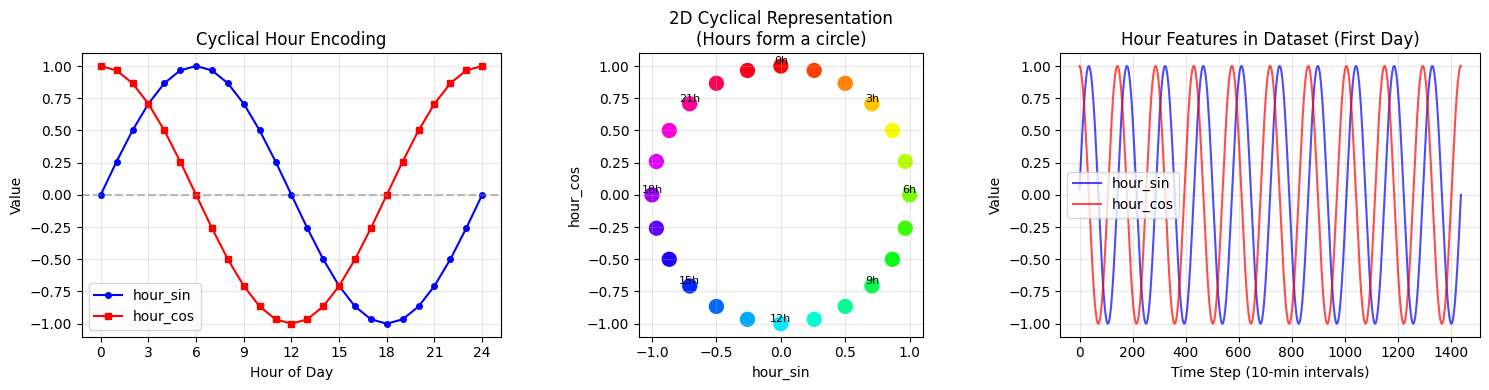


✓ Hour encoding visualization complete
Note: Hour 0 and Hour 23 are adjacent in the 2D (sin,cos) space, preserving cyclical nature.


In [17]:
# Visualize the cyclical hour-of-day encoding

# Create sample hours for visualization
hours = np.arange(0, 25)  # 0-24 to show wrap-around
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sin and Cos over 24 hours
axes[0].plot(hours, hour_sin, 'b-o', label='hour_sin', markersize=4)
axes[0].plot(hours, hour_cos, 'r-s', label='hour_cos', markersize=4)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Value')
axes[0].set_title('Cyclical Hour Encoding')
axes[0].legend()
axes[0].set_xticks(range(0, 25, 3))
axes[0].grid(True, alpha=0.3)

# Plot 2: 2D representation (sin vs cos) - shows cyclical nature
axes[1].scatter(hour_sin[:24], hour_cos[:24], c=hours[:24], cmap='hsv', s=100)
for h in range(0, 24, 3):
    axes[1].annotate(f'{h}h', (hour_sin[h], hour_cos[h]), fontsize=8, ha='center', va='bottom')
axes[1].set_xlabel('hour_sin')
axes[1].set_ylabel('hour_cos')
axes[1].set_title('2D Cyclical Representation\n(Hours form a circle)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Plot 3: Sample from actual data (if available)
if 'df_enhanced' in dir() and df_enhanced is not None:
    sample = df_enhanced[['hour_sin', 'hour_cos']].iloc[:1440]  # ~1 day at 10-min intervals
    axes[2].plot(sample['hour_sin'].values, 'b-', label='hour_sin', alpha=0.7)
    axes[2].plot(sample['hour_cos'].values, 'r-', label='hour_cos', alpha=0.7)
    axes[2].set_xlabel('Time Step (10-min intervals)')
    axes[2].set_ylabel('Value')
    axes[2].set_title('Hour Features in Dataset (First Day)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Load dataset to see\nactual hour features', 
                 ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Hour Features in Dataset')

plt.tight_layout()
plt.show()

print("\n✓ Hour encoding visualization complete")
print("Note: Hour 0 and Hour 23 are adjacent in the 2D (sin,cos) space, preserving cyclical nature.")

✓ Dataset found at: /content/PatchTST/datasets/weather/weather_with_hour.csv

Dataset shape: (52696, 24)

First few rows:
                  date  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
1  2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2  2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
3  2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
4  2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  wd (deg)  \
0          6.43          5.54          0.89       3.42  ...     224.3   
1          6.45          5.49          0.95       3.39  ...     206.8   
2          6.44          5.48          0.96       3.39  ...     197.1   
3          6.27          5.41          0.86       3.35  ...     206.4   
4          6.26          5.47          0.79       

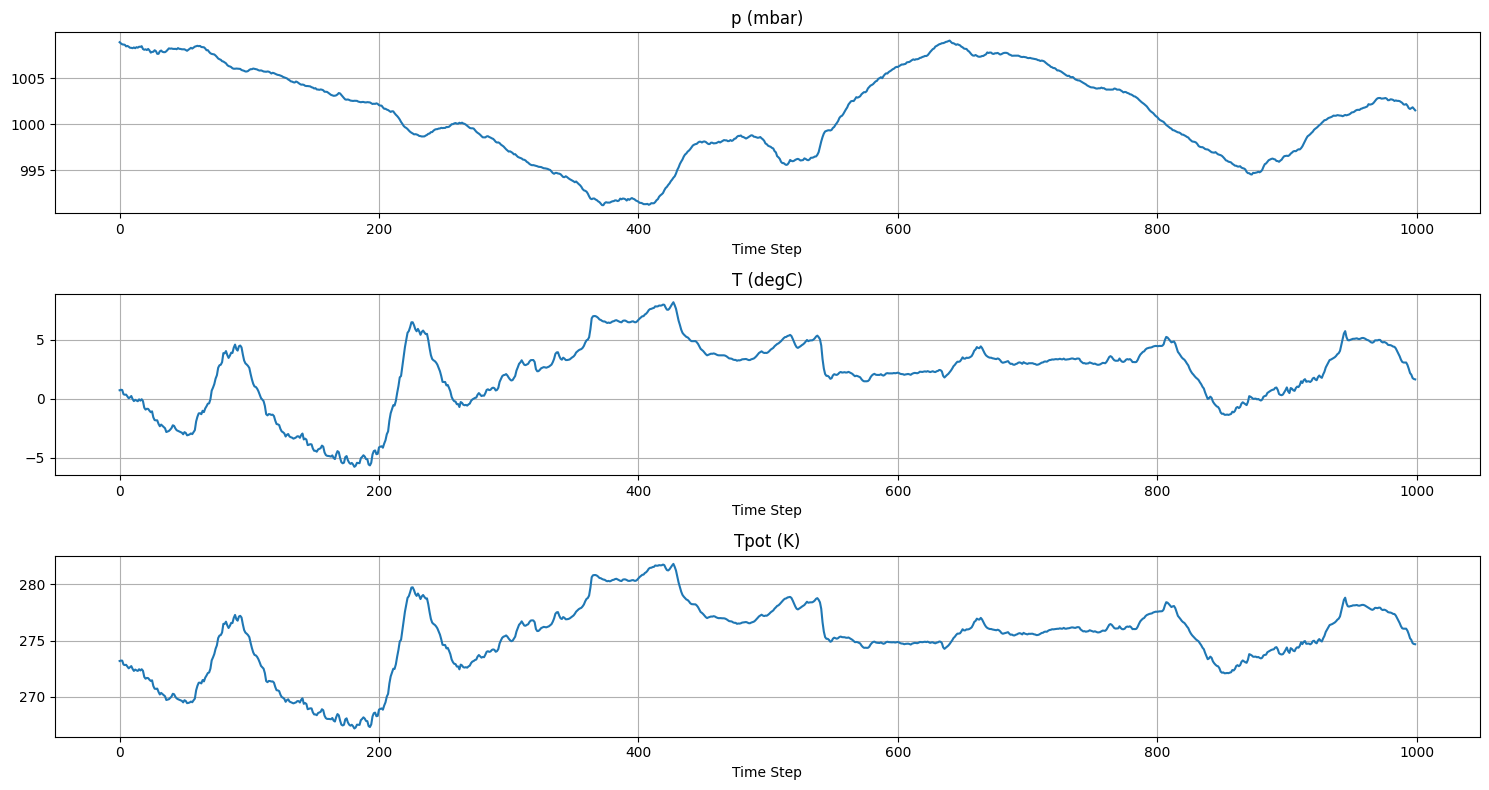

In [18]:
# Check if dataset exists
dataset_path = os.path.join(args.root_path, args.data_path)
if os.path.exists(dataset_path):
    print(f"✓ Dataset found at: {dataset_path}")
    
    # Load and explore the dataset
    df = pd.read_csv(dataset_path)
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData types:")
    print(df.dtypes)
    
    # Visualize a sample of the data
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    for i, col in enumerate(df.columns[1:4]):
        axes[i].plot(df[col][:1000])
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('Time Step')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"✗ Dataset not found at: {dataset_path}")
    print(f"\nPlease download the dataset from:")
    print(f"https://drive.google.com/drive/folders/1ZOYpTUa82_jCcxIdTmyr0LXQfvaM9vIy")
    print(f"\nAnd place it in the {args.root_path} folder")

In [19]:
train_data, train_loader = data_provider(args, flag='train')
val_data, val_loader = data_provider(args, flag='val')
test_data, test_loader = data_provider(args, flag='test')

print(f"\nData Loaders Created:")
print(f"  Training samples: {len(train_data)}")
print(f"  Validation samples: {len(val_data)}")
print(f"  Test samples: {len(test_data)}")

# Inspect a batch
for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
    print(f"\nBatch shapes:")
    print(f"  Input (batch_x): {batch_x.shape}")
    print(f"  Target (batch_y): {batch_y.shape}")
    print(f"  Input time features (batch_x_mark): {batch_x_mark.shape}")
    print(f"  Target time features (batch_y_mark): {batch_y_mark.shape}")
    break

train 36040
val 4935
test 10204

Data Loaders Created:
  Training samples: 36040
  Validation samples: 4935
  Test samples: 10204

Batch shapes:
  Input (batch_x): torch.Size([32, 512, 23])
  Target (batch_y): torch.Size([32, 384, 23])
  Input time features (batch_x_mark): torch.Size([32, 512, 5])
  Target time features (batch_y_mark): torch.Size([32, 384, 5])
test 10204

Data Loaders Created:
  Training samples: 36040
  Validation samples: 4935
  Test samples: 10204

Batch shapes:
  Input (batch_x): torch.Size([32, 512, 23])
  Target (batch_y): torch.Size([32, 384, 23])
  Input time features (batch_x_mark): torch.Size([32, 512, 5])
  Target time features (batch_y_mark): torch.Size([32, 384, 5])


## 4. Physics-Integrated Model Definition <a id='model'></a>

This model has a key design difference from the previous version:

**Hour features are INTEGRATED into physics groups** - The same hour_sin/hour_cos channels are fed to multiple encoders (thermodynamics, moisture, precipitation), allowing each to learn the hour-physics correlation at its appropriate time scale.

**Output is weather-only** - We predict 21 weather channels, not the hour features (which are deterministic from timestamps).

In [20]:
# Physics-Integrated PatchTST Model
# Hour features are integrated INTO physics groups, not kept separate

class PerChannelEncoder(nn.Module):
    """Encoder for a group of channels with specific patch length.
    
    For groups with hour features integrated, the encoder learns
    the correlation between hour-of-day and physics variables directly.
    """
    def __init__(self, n_input_channels, n_output_channels, context_window, target_window, 
                 patch_len, stride, n_layers=3, d_model=128, n_heads=8, d_ff=256, 
                 dropout=0.2, head_dropout=0.0, padding_patch='end'):
        super().__init__()
        
        self.n_input_channels = n_input_channels   # Includes hour features if integrated
        self.n_output_channels = n_output_channels  # Only weather channels
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.d_model = d_model
        
        # Calculate patch count
        patch_num = int((context_window - patch_len) / stride + 1)
        if padding_patch == 'end':
            self.padding_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1
        self.patch_num = patch_num
        
        # Patch embedding (project patch_len → d_model)
        self.W_P = nn.Linear(patch_len, d_model)
        
        # Positional encoding (learnable)
        self.W_pos = nn.Parameter(torch.zeros(1, patch_num, d_model))
        nn.init.normal_(self.W_pos, std=0.02)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Per-channel prediction heads (only for OUTPUT channels, not hour features)
        self.head_nf = d_model * patch_num
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Flatten(start_dim=-2),
                nn.Linear(self.head_nf, target_window),
                nn.Dropout(head_dropout)
            ) for _ in range(n_output_channels)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, output_channel_mask):
        """
        Args:
            x: [bs, n_input_channels, seq_len] - includes hour features if integrated
            output_channel_mask: list of bools, True for channels to output
        Returns:
            outputs: [bs, n_output_channels, pred_len] - only weather channels
        """
        bs, n_ch, seq_len = x.shape
        
        # Padding if needed
        if self.padding_patch == 'end':
            x = self.padding_layer(x)
        
        # Create patches: [bs, n_channels, patch_num, patch_len]
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        
        # Process each channel independently
        outputs = []
        head_idx = 0
        
        for ch in range(n_ch):
            ch_x = x[:, ch, :, :]  # [bs, patch_num, patch_len]
            
            # Project patches to d_model
            ch_x = self.W_P(ch_x)  # [bs, patch_num, d_model]
            
            # Add positional encoding
            ch_x = self.dropout(ch_x + self.W_pos)
            
            # Transformer encoder (channel-independent)
            ch_z = self.encoder(ch_x)  # [bs, patch_num, d_model]
            
            # Only create output for weather channels, not hour features
            if output_channel_mask[ch]:
                ch_out = self.heads[head_idx](ch_z)  # [bs, target_window]
                outputs.append(ch_out)
                head_idx += 1
        
        # Stack outputs: [bs, n_output_channels, target_window]
        output = torch.stack(outputs, dim=1)
        return output


class PhysicsIntegratedPatchTST(nn.Module):
    """
    Physics-Integrated PatchTST with hour features embedded in physics groups.
    
    Key Features:
    - Hour features (hour_sin, hour_cos) are fed to multiple physics encoders
    - Each encoder learns hour-physics correlations at its appropriate time scale
    - Only weather channels are predicted (hour features are input-only)
    """
    def __init__(self, configs):
        super().__init__()
        
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.enc_in = configs.enc_in  # 23 (21 weather + 2 hour)
        self.c_out = configs.c_out    # 21 (weather only)
        self.channel_groups = configs.channel_groups
        self.patch_configs = configs.patch_configs
        self.hour_indices = set(configs.hour_feature_indices)  # {21, 22}
        
        # RevIN for normalization (all input channels)
        self.revin = configs.revin
        if self.revin:
            self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, 
                                      subtract_last=configs.subtract_last)
        
        # Create encoder for each channel group
        self.encoders = nn.ModuleDict()
        self.group_info = {}
        
        for group_name, group_info in self.channel_groups.items():
            indices = group_info['indices']
            patch_config = self.patch_configs[group_name]
            
            # Separate weather channels from hour channels in this group
            weather_indices = [i for i in indices if i not in self.hour_indices]
            hour_indices_in_group = [i for i in indices if i in self.hour_indices]
            
            # Create mask: True for weather channels, False for hour channels
            output_mask = [i not in self.hour_indices for i in indices]
            
            self.group_info[group_name] = {
                'all_indices': indices,
                'weather_indices': weather_indices,
                'hour_indices': hour_indices_in_group,
                'output_mask': output_mask,
                'n_input': len(indices),
                'n_output': len(weather_indices)
            }
            
            self.encoders[group_name] = PerChannelEncoder(
                n_input_channels=len(indices),
                n_output_channels=len(weather_indices),  # Only predict weather
                context_window=configs.seq_len,
                target_window=configs.pred_len,
                patch_len=patch_config['patch_len'],
                stride=patch_config['stride'],
                n_layers=configs.e_layers,
                d_model=configs.d_model,
                n_heads=configs.n_heads,
                d_ff=configs.d_ff,
                dropout=configs.dropout,
                head_dropout=configs.head_dropout,
                padding_patch=configs.padding_patch
            )
        
        self.group_weights = {name: cfg['weight'] for name, cfg in self.patch_configs.items()}
        
    def forward(self, x):
        """
        Args:
            x: [bs, seq_len, 23] - 21 weather + 2 hour features
        Returns:
            output: [bs, pred_len, 21] - only weather predictions
        """
        bs = x.shape[0]
        
        # Permute to [bs, enc_in, seq_len]
        x = x.permute(0, 2, 1)
        
        # Apply RevIN normalization
        if self.revin:
            x = x.permute(0, 2, 1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0, 2, 1)
        
        # Initialize output for weather channels only
        all_outputs = torch.zeros(bs, self.c_out, self.pred_len, device=x.device)
        
        for group_name, encoder in self.encoders.items():
            info = self.group_info[group_name]
            
            # Extract all channels for this group (including hour features)
            group_x = x[:, info['all_indices'], :]
            
            # Encode - returns only weather channel outputs
            group_out = encoder(group_x, info['output_mask'])
            
            # Place weather outputs in correct positions
            for i, ch_idx in enumerate(info['weather_indices']):
                all_outputs[:, ch_idx, :] = group_out[:, i, :]
        
        # Permute to [bs, pred_len, c_out]
        output = all_outputs.permute(0, 2, 1)
        
        # Apply RevIN denormalization (only for weather channels)
        if self.revin:
            # Need to handle the dimension mismatch for denorm
            # Create a temporary tensor with all channels for denorm
            temp_output = torch.zeros(bs, self.pred_len, self.enc_in, device=x.device)
            temp_output[:, :, :self.c_out] = output
            temp_output = self.revin_layer(temp_output, 'denorm')
            output = temp_output[:, :, :self.c_out]
        
        return output


# Create the Physics-Integrated model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = PhysicsIntegratedPatchTST(args).float()
model = model.to(device)

print(f"\n✓ Physics-Integrated PatchTST Model Created!")
print(f"\nModel Configuration:")
print(f"  Input channels: {args.enc_in} (21 weather + 2 hour)")
print(f"  Output channels: {args.c_out} (21 weather only)")
print(f"  Hour features integrated into: thermodynamics, moisture, precipitation")

print(f"\nGroup Details:")
for group_name, info in model.group_info.items():
    print(f"  {group_name}:")
    print(f"    Input channels: {info['n_input']} (weather: {info['n_output']}, hour: {len(info['hour_indices'])})")
    print(f"    Patch length: {args.patch_configs[group_name]['patch_len']} steps")

print(f"\nModel Structure:")
print(model)

Using device: cuda:0

✓ Physics-Integrated PatchTST Model Created!

Model Configuration:
  Input channels: 23 (21 weather + 2 hour)
  Output channels: 21 (21 weather only)
  Hour features integrated into: thermodynamics, moisture, precipitation

Group Details:
  thermodynamics:
    Input channels: 10 (weather: 8, hour: 2)
    Patch length: 48 steps
  moisture:
    Input channels: 9 (weather: 7, hour: 2)
    Patch length: 32 steps
  precipitation:
    Input channels: 4 (weather: 2, hour: 2)
    Patch length: 12 steps
  atmospheric_dynamics:
    Input channels: 4 (weather: 4, hour: 0)
    Patch length: 24 steps

Model Structure:
PhysicsIntegratedPatchTST(
  (revin_layer): RevIN()
  (encoders): ModuleDict(
    (thermodynamics): PerChannelEncoder(
      (padding_layer): ReplicationPad1d((0, 24))
      (W_P): Linear(in_features=48, out_features=128, bias=True)
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_a

In [21]:
# Detailed model analysis
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"\nModel Parameters:")
print(f"  Total parameters: {total:,}")
print(f"  Trainable parameters: {trainable:,}")
print(f"  Model size: ~{total * 4 / 1024 / 1024:.2f} MB (fp32)")

# Per-encoder breakdown
print(f"\nPer-Group Encoder Details:")
print("=" * 70)
for group_name, encoder in model.encoders.items():
    group_params = sum(p.numel() for p in encoder.parameters())
    group_info = args.channel_groups[group_name]
    patch_cfg = args.patch_configs[group_name]
    
    print(f"\n{group_name.upper()} Encoder:")
    print(f"  Channels: {len(group_info['indices'])} ({group_info['names'][:2]}...)")
    print(f"  Patch length: {patch_cfg['patch_len']} steps ({patch_cfg['patch_len']*10} min)")
    print(f"  Stride: {patch_cfg['stride']} steps ({patch_cfg['stride']*10} min)")
    print(f"  Patches per channel: {encoder.patch_num}")
    print(f"  Parameters: {group_params:,}")
    print(f"  Fusion weight: {patch_cfg['weight']}")
print("=" * 70)


Model Parameters:
  Total parameters: 33,031,056
  Trainable parameters: 33,031,056
  Model size: ~126.00 MB (fp32)

Per-Group Encoder Details:

THERMODYNAMICS Encoder:
  Channels: 10 (['T (degC)', 'Tpot (K)']...)
  Patch length: 48 steps (480 min)
  Stride: 24 steps (240 min)
  Patches per channel: 21
  Parameters: 7,634,432
  Fusion weight: 0.35

MOISTURE Encoder:
  Channels: 9 (['rh (%)', 'VPmax (mbar)']...)
  Patch length: 32 steps (320 min)
  Stride: 16 steps (160 min)
  Patches per channel: 32
  Parameters: 10,041,904
  Fusion weight: 0.3

PRECIPITATION Encoder:
  Channels: 4 (['rain (mm)', 'raining (s)']...)
  Patch length: 12 steps (120 min)
  Stride: 6 steps (60 min)
  Patches per channel: 85
  Parameters: 7,722,016
  Fusion weight: 0.15

ATMOSPHERIC_DYNAMICS Encoder:
  Channels: 4 (['p (mbar)', 'wv (m/s)']...)
  Patch length: 24 steps (240 min)
  Stride: 12 steps (120 min)
  Patches per channel: 42
  Parameters: 7,632,704
  Fusion weight: 0.2


In [22]:
# Test forward pass with dummy data
batch_size = 4
dummy_input = torch.randn(batch_size, args.seq_len, args.enc_in).to(device)

print(f"\nTesting forward pass...")
print(f"Input shape: {dummy_input.shape}")
print(f"Expected: [batch={batch_size}, seq_len={args.seq_len}, channels={args.enc_in}]")

with torch.no_grad():
    dummy_output = model(dummy_input)
    
print(f"\nOutput shape: {dummy_output.shape}")
print(f"Expected: [batch={batch_size}, pred_len={args.pred_len}, channels={args.c_out}]")

# Verify each channel group was processed
print(f"\n✓ Forward pass successful!")
print(f"\nChannel Processing Summary:")
for group_name, info in model.group_info.items():
    patch_cfg = args.patch_configs[group_name]
    hour_str = f" (+hour)" if len(info['hour_indices']) > 0 else ""
    print(f"  {group_name}: {info['n_input']} input → {info['n_output']} output{hour_str}, patch={patch_cfg['patch_len']}")


Testing forward pass...
Input shape: torch.Size([4, 512, 23])
Expected: [batch=4, seq_len=512, channels=23]

Output shape: torch.Size([4, 336, 21])
Expected: [batch=4, pred_len=336, channels=21]

✓ Forward pass successful!

Channel Processing Summary:
  thermodynamics: 10 input → 8 output (+hour), patch=48
  moisture: 9 input → 7 output (+hour), patch=32
  precipitation: 4 input → 2 output (+hour), patch=12
  atmospheric_dynamics: 4 input → 4 output, patch=24


## 5. Training the Model <a id='training'></a>

Now let's set up the training loop with proper optimization and learning rate scheduling.

In [23]:
# Fix NumPy 2.0 compatibility issue
import numpy as np
if not hasattr(np, 'Inf'):
    np.Inf = np.inf
    np.NaN = np.nan
    np.NAN = np.nan
    np.NINF = np.NINF if hasattr(np, 'NINF') else -np.inf
    print("NumPy compatibility patch applied for np.Inf -> np.inf")
else:
    print("NumPy already has np.Inf attribute")

NumPy compatibility patch applied for np.Inf -> np.inf


In [24]:
from utils.tools import EarlyStopping, adjust_learning_rate
from utils.metrics import metric
import time

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

# Learning rate scheduler
if os.path.exists(dataset_path):
    train_steps = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        steps_per_epoch=train_steps,
        pct_start=args.pct_start,
        epochs=args.train_epochs,
        max_lr=args.learning_rate
    )
    
    print(f"Training Setup:")
    print(f"  Criterion: MSE Loss")
    print(f"  Optimizer: Adam (lr={args.learning_rate})")
    print(f"  Scheduler: OneCycleLR")
    print(f"  Training steps per epoch: {train_steps}")
    print(f"  Total epochs: {args.train_epochs}")

Training Setup:
  Criterion: MSE Loss
  Optimizer: Adam (lr=0.0001)
  Scheduler: OneCycleLR
  Training steps per epoch: 1126
  Total epochs: 100


In [25]:
# Validation function (handles 21-channel output vs 23-channel target)
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in val_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            
            # Forward pass - outputs only weather channels (21)
            outputs = model(batch_x)  # [bs, pred_len, 21]
            
            # Target - extract only weather channels (first 21)
            outputs = outputs[:, -args.pred_len:, :]
            batch_y = batch_y[:, -args.pred_len:, :args.c_out]  # Only weather channels
            
            loss = criterion(outputs.cpu(), batch_y.cpu())
            total_loss.append(loss.item())
    
    model.train()
    return np.mean(total_loss)

print("Validation function defined.")
print(f"  Model output: {args.c_out} channels (weather only)")
print(f"  Target comparison: first {args.c_out} channels of batch_y")

Validation function defined.
  Model output: 21 channels (weather only)
  Target comparison: first 21 channels of batch_y


In [26]:
# Training loop for Physics-Integrated PatchTST
import time

# Setup checkpoint directory
setting = f"PhysicsIntegrated_{args.data}_sl{args.seq_len}_pl{args.pred_len}"
checkpoint_path = os.path.join(args.checkpoints, setting)
os.makedirs(checkpoint_path, exist_ok=True)

# Early stopping
early_stopping = EarlyStopping(patience=args.patience, verbose=True)

# Training history
train_losses = []
val_losses = []
test_losses = []

# Per-group losses (for analysis) - only for weather channels
group_train_losses = {name: [] for name in args.channel_groups.keys()}

print(f"\nStarting Physics-Integrated PatchTST Training...")
print(f"Checkpoint path: {checkpoint_path}")
print("=" * 70)
print(f"Input channels: {args.enc_in} (21 weather + 2 hour)")
print(f"Output channels: {args.c_out} (21 weather only)")
print("─" * 70)
print(f"Physics Groups (with integrated hour features):")
for name, cfg in args.patch_configs.items():
    info = model.group_info[name]
    hour_str = f"+hour" if len(info['hour_indices']) > 0 else ""
    print(f"  {name}: {info['n_output']} weather{hour_str} → patch={cfg['patch_len']}")
print("=" * 70)

for epoch in range(args.train_epochs):
    model.train()
    epoch_time = time.time()
    train_loss = []
    batch_group_losses = {name: [] for name in args.channel_groups.keys()}
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_x = batch_x.float().to(device)  # [bs, seq_len, 23]
        batch_y = batch_y.float().to(device)  # [bs, pred_len, 23]
        
        # Forward pass - outputs only weather channels
        outputs = model(batch_x)  # [bs, pred_len, 21]
        
        # Target - only weather channels (first 21)
        outputs = outputs[:, -args.pred_len:, :]
        batch_y_weather = batch_y[:, -args.pred_len:, :args.c_out]
        
        # Total loss
        loss = criterion(outputs, batch_y_weather)
        train_loss.append(loss.item())
        
        # Per-group loss tracking (for analysis) - only weather channels
        with torch.no_grad():
            for group_name in args.channel_groups.keys():
                info = model.group_info[group_name]
                weather_indices = info['weather_indices']
                if len(weather_indices) > 0:
                    group_out = outputs[:, :, weather_indices]
                    group_true = batch_y_weather[:, :, weather_indices]
                    group_loss = criterion(group_out, group_true)
                    batch_group_losses[group_name].append(group_loss.item())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Progress update every 100 batches
        if (i + 1) % 100 == 0:
            print(f"  Epoch {epoch+1} | Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.6f}")
    
    # Epoch statistics
    train_loss_avg = np.mean(train_loss)
    val_loss = validate(model, val_loader, criterion, device)
    test_loss = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    # Store per-group losses
    for group_name in args.channel_groups.keys():
        if len(batch_group_losses[group_name]) > 0:
            group_train_losses[group_name].append(np.mean(batch_group_losses[group_name]))
    
    epoch_duration = time.time() - epoch_time
    
    print(f"\nEpoch {epoch+1}/{args.train_epochs} | Time: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss_avg:.7f} | Val Loss: {val_loss:.7f} | Test Loss: {test_loss:.7f}")
    print(f"  Per-Group Train Losses (weather channels only):")
    for group_name in args.channel_groups.keys():
        if len(batch_group_losses[group_name]) > 0:
            print(f"    {group_name}: {np.mean(batch_group_losses[group_name]):.7f}")
    
    # Early stopping check
    early_stopping(val_loss, model, checkpoint_path)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered!")
        break
    
    # Adjust learning rate
    if args.lradj != 'TST':
        adjust_learning_rate(optimizer, scheduler, epoch + 1, args)

print("=" * 70)
print("Training completed!")

# Load best model
best_model_path = os.path.join(checkpoint_path, 'checkpoint.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=False))
print(f"Best model loaded from: {best_model_path}")


Starting Physics-Integrated PatchTST Training...
Checkpoint path: /content/model/checkpoints_physics_integrated/PhysicsIntegrated_custom_sl512_pl336
Input channels: 23 (21 weather + 2 hour)
Output channels: 21 (21 weather only)
──────────────────────────────────────────────────────────────────────
Physics Groups (with integrated hour features):
  thermodynamics: 8 weather+hour → patch=48
  moisture: 7 weather+hour → patch=32
  precipitation: 2 weather+hour → patch=12
  atmospheric_dynamics: 4 weather → patch=24
  Epoch 1 | Batch 100/1126 | Loss: 0.641395
  Epoch 1 | Batch 100/1126 | Loss: 0.641395
  Epoch 1 | Batch 200/1126 | Loss: 0.573170
  Epoch 1 | Batch 200/1126 | Loss: 0.573170
  Epoch 1 | Batch 300/1126 | Loss: 0.566783
  Epoch 1 | Batch 300/1126 | Loss: 0.566783
  Epoch 1 | Batch 400/1126 | Loss: 0.482581
  Epoch 1 | Batch 400/1126 | Loss: 0.482581
  Epoch 1 | Batch 500/1126 | Loss: 0.409609
  Epoch 1 | Batch 500/1126 | Loss: 0.409609
  Epoch 1 | Batch 600/1126 | Loss: 0.44253

In [27]:
# Plot training history with per-group breakdown
if os.path.exists(dataset_path) and len(train_losses) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Overall training curves
    axes[0, 0].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 0].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 0].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].set_title('Overall Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Log scale
    axes[0, 1].plot(train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 1].plot(val_losses, label='Validation Loss', marker='s', markersize=3)
    axes[0, 1].plot(test_losses, label='Test Loss', marker='^', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE Loss (log scale)')
    axes[0, 1].set_title('Training History (Log Scale)')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Per-group training losses (Physics-based colors)
    colors = {
        'atmospheric_dynamics': 'blue',
        'thermodynamics': 'red',
        'moisture': 'green',
        'precipitation': 'cyan',
        'temporal': 'purple'
    }
    for group_name, losses in group_train_losses.items():
        if len(losses) > 0:
            patch_len = args.patch_configs[group_name]['patch_len']
            color = colors.get(group_name, 'gray')
            axes[1, 0].plot(losses, label=f'{group_name} (patch={patch_len})', 
                           color=color, marker='o', markersize=3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].set_title('Per-Group Training Losses (Physics-Based Grouping)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Final per-group comparison (bar chart)
    first_group = list(group_train_losses.keys())[0]
    if len(group_train_losses[first_group]) > 0:
        group_names = list(group_train_losses.keys())
        final_losses = [group_train_losses[name][-1] for name in group_names]
        patch_lens = [args.patch_configs[name]['patch_len'] for name in group_names]
        
        bars = axes[1, 1].bar(range(len(group_names)), final_losses, 
                              color=[colors.get(n, 'gray') for n in group_names])
        axes[1, 1].set_xticks(range(len(group_names)))
        axes[1, 1].set_xticklabels([n.replace('_', '\n') for n in group_names], fontsize=8)
        axes[1, 1].set_xlabel('Physics Group')
        axes[1, 1].set_ylabel('Final Training MSE')
        axes[1, 1].set_title('Final Loss by Physics Group')
        
        # Add patch length annotations
        for bar, pl in zip(bars, patch_lens):
            axes[1, 1].annotate(f'p={pl}', 
                               xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                               ha='center', va='bottom', fontsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 6. Model Checkpointing <a id='checkpointing'></a>

Learn how to save and load model checkpoints.

In [28]:
# Save model checkpoint with additional information
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'config': vars(args)
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to: {filepath}")

# Save current model
if os.path.exists(dataset_path):
    custom_checkpoint_path = os.path.join(checkpoint_path, 'model_final.pth')
    save_checkpoint(
        model, 
        optimizer, 
        args.train_epochs,
        train_losses[-1] if train_losses else 0,
        val_losses[-1] if val_losses else 0,
        custom_checkpoint_path
    )

Checkpoint saved to: /content/model/checkpoints_physics_integrated/PhysicsIntegrated_custom_sl512_pl336/model_final.pth


In [29]:
# Load model checkpoint
def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', None)
    val_loss = checkpoint.get('val_loss', None)
    
    print(f"Checkpoint loaded from: {filepath}")
    print(f"  Epoch: {epoch}")
    if train_loss is not None:
        print(f"  Train Loss: {train_loss:.7f}")
    if val_loss is not None:
        print(f"  Val Loss: {val_loss:.7f}")
    
    return model, optimizer, epoch

# Example: Load the saved checkpoint
if os.path.exists(dataset_path):
    if os.path.exists(custom_checkpoint_path):
        model, optimizer, epoch = load_checkpoint(custom_checkpoint_path, model, optimizer)
    else:
        print("No checkpoint found to load.")

Checkpoint loaded from: /content/model/checkpoints_physics_integrated/PhysicsIntegrated_custom_sl512_pl336/model_final.pth
  Epoch: 100
  Train Loss: 0.3978975
  Val Loss: 0.5530022


## 7. Evaluation and Visualization <a id='evaluation'></a>

Evaluate the model on the test set and visualize predictions.

In [42]:
# Comprehensive evaluation with per-group analysis (21 weather channels only)
def evaluate_physics_integrated_model(model, test_loader, device, args):
    model.eval()
    preds = []
    trues = []
    inputs = []
    
    with torch.no_grad():
        for batch_x, batch_y, batch_x_mark, batch_y_mark in test_loader:
            batch_x = batch_x.float().to(device)  # [bs, seq_len, 23]
            batch_y = batch_y.float().to(device)  # [bs, pred_len, 23]
            
            # Forward pass - outputs only weather channels (21)
            outputs = model(batch_x)  # [bs, pred_len, 21]
            
            # Extract predictions (weather only)
            outputs = outputs[:, -args.pred_len:, :]
            batch_y_weather = batch_y[:, -args.pred_len:, :args.c_out]  # First 21 channels
            
            preds.append(outputs.detach().cpu().numpy())
            trues.append(batch_y_weather.detach().cpu().numpy())
            inputs.append(batch_x.detach().cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    inputs = np.concatenate(inputs, axis=0)
    
    # Overall metrics (21 weather channels)
    mae, mse, rmse, mape, mspe, rse, corr = metric(preds, trues)
    
    print("\n" + "=" * 70)
    print("Physics-Integrated PatchTST - Test Set Evaluation")
    print("=" * 70)
    print(f"\nOVERALL METRICS (21 weather channels):")
    print(f"  MSE:  {mse:.7f}")
    print(f"  MAE:  {mae:.7f}")
    print(f"  RMSE: {rmse:.7f}")
    print(f"  MAPE: {mape:.7f}")
    
    # Per-group metrics (weather channels only)
    print(f"\nPER-GROUP METRICS (weather channels only):")
    group_metrics = {}
    for group_name in args.channel_groups.keys():
        info = model.group_info[group_name]
        weather_indices = info['weather_indices']
        patch_len = args.patch_configs[group_name]['patch_len']
        
        if len(weather_indices) > 0:
            group_preds = preds[:, :, weather_indices]
            group_trues = trues[:, :, weather_indices]
            
            g_mae, g_mse, g_rmse, g_mape, _, _, _ = metric(group_preds, group_trues)
            group_metrics[group_name] = {'mse': g_mse, 'mae': g_mae, 'rmse': g_rmse}
            
            hour_str = f"+hour" if len(info['hour_indices']) > 0 else ""
            print(f"\n  {group_name.upper()} (patch={patch_len}, {len(weather_indices)} weather{hour_str}):")
            print(f"    MSE:  {g_mse:.7f}")
            print(f"    MAE:  {g_mae:.7f}")
            print(f"    RMSE: {g_rmse:.7f}")
    
    print("=" * 70)
    
    return preds, trues, inputs, {'overall': {'mse': mse, 'mae': mae}, 'groups': group_metrics}

# Run evaluation
if os.path.exists(dataset_path):
    preds, trues, inputs, metrics = evaluate_physics_integrated_model(model, test_loader, device, args)


Physics-Integrated PatchTST - Test Set Evaluation

OVERALL METRICS (21 weather channels):
  MSE:  0.2518811
  MAE:  0.2918433
  RMSE: 0.5018775
  MAPE: 12.8122997

PER-GROUP METRICS (weather channels only):

  THERMODYNAMICS (patch=48, 8 weather+hour):
    MSE:  0.2181186
    MAE:  0.2225817
    RMSE: 0.4670317

  THERMODYNAMICS (patch=48, 8 weather+hour):
    MSE:  0.2181186
    MAE:  0.2225817
    RMSE: 0.4670317

  MOISTURE (patch=32, 7 weather+hour):
    MSE:  0.2861997
    MAE:  0.3564045
    RMSE: 0.5349764

  PRECIPITATION (patch=12, 2 weather+hour):
    MSE:  0.1425405
    MAE:  0.2001319
    RMSE: 0.3775454

  MOISTURE (patch=32, 7 weather+hour):
    MSE:  0.2861997
    MAE:  0.3564045
    RMSE: 0.5349764

  PRECIPITATION (patch=12, 2 weather+hour):
    MSE:  0.1425405
    MAE:  0.2001319
    RMSE: 0.3775454

  ATMOSPHERIC_DYNAMICS (patch=24, 4 weather):
    MSE:  0.3140193
    MAE:  0.3632366
    RMSE: 0.5603743

  ATMOSPHERIC_DYNAMICS (patch=24, 4 weather):
    MSE:  0.3140

preds shape: (10176, 336, 21), trues shape: (10176, 336, 21), inputs shape: (10176, 512, 23)


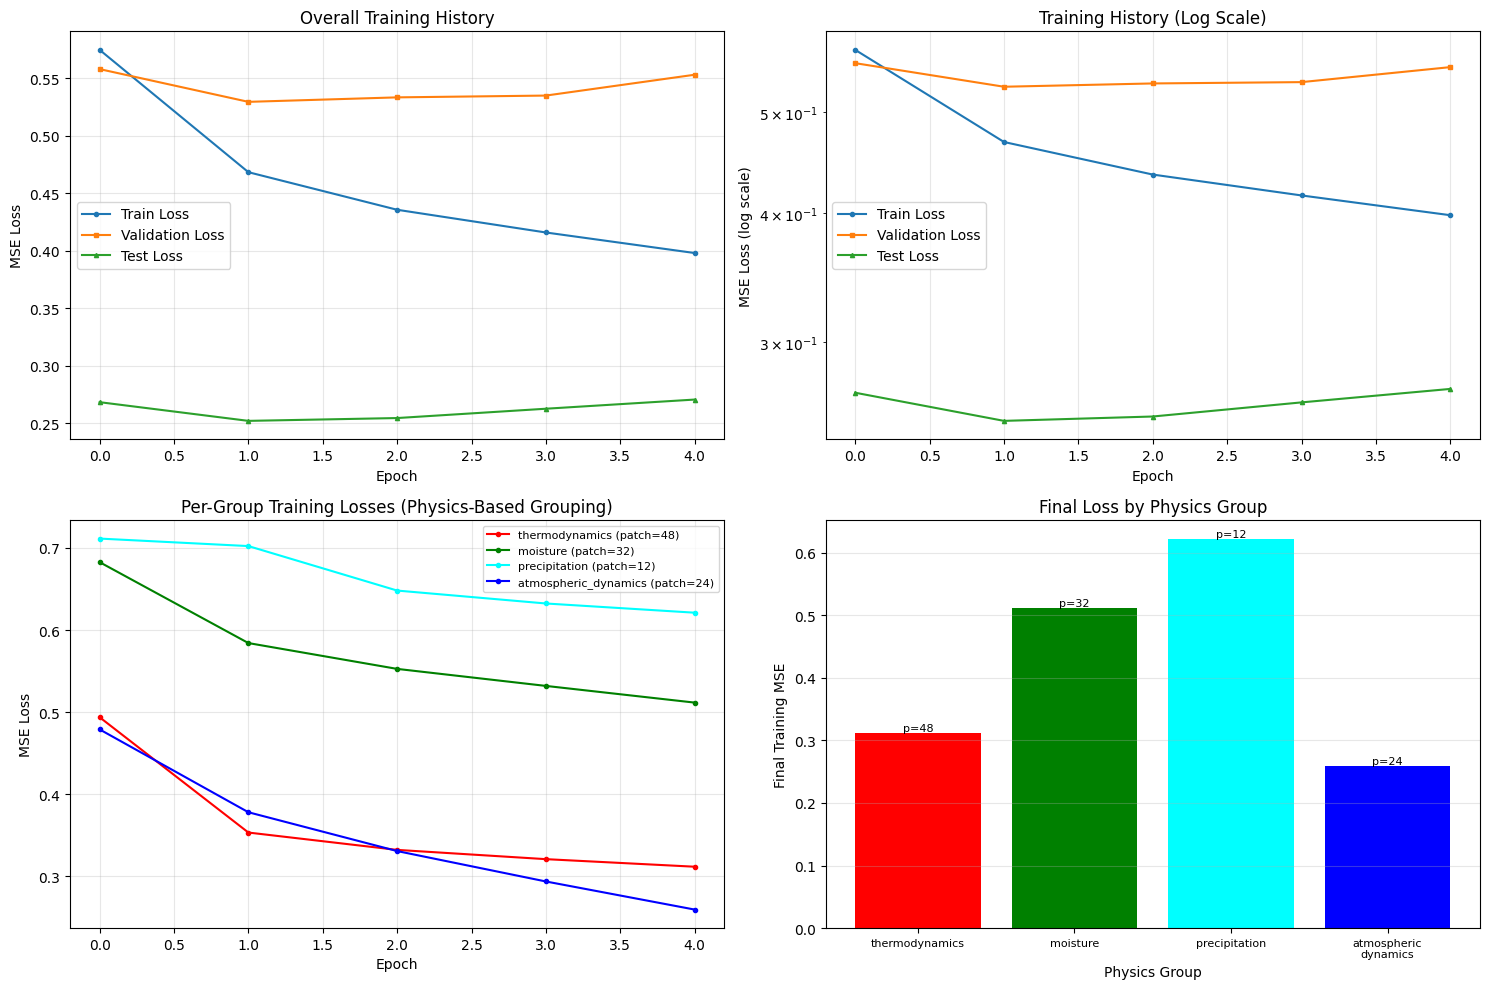

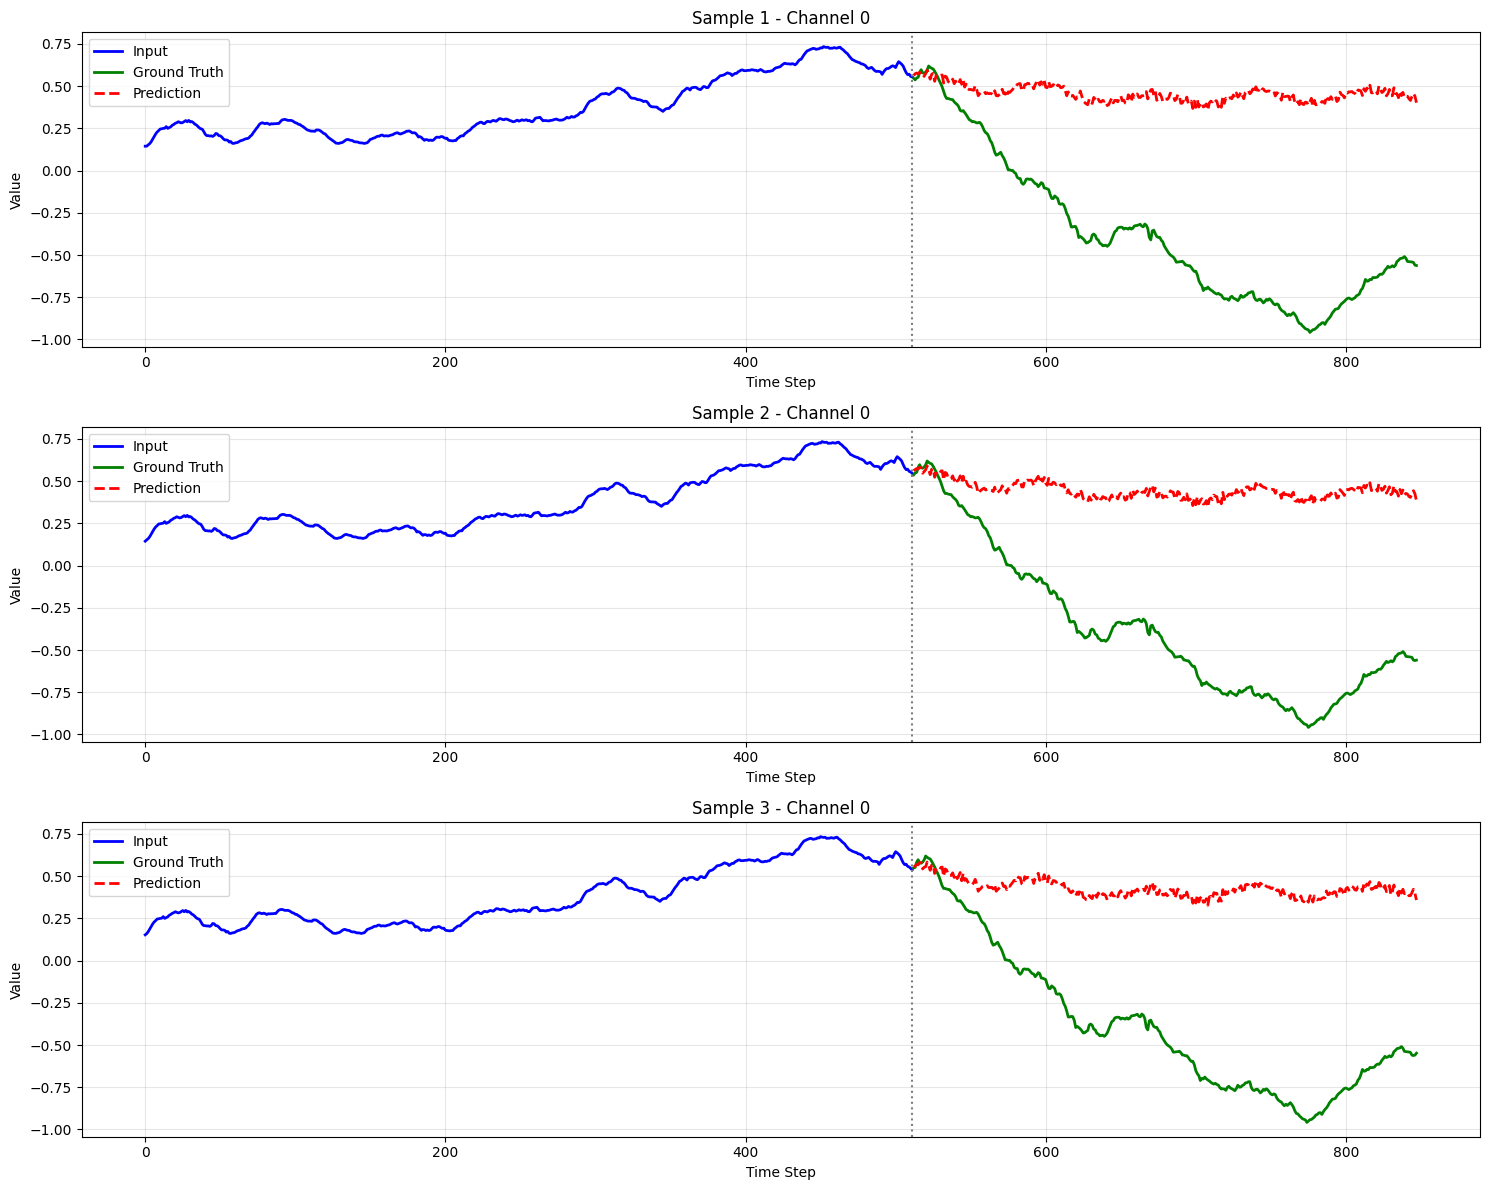

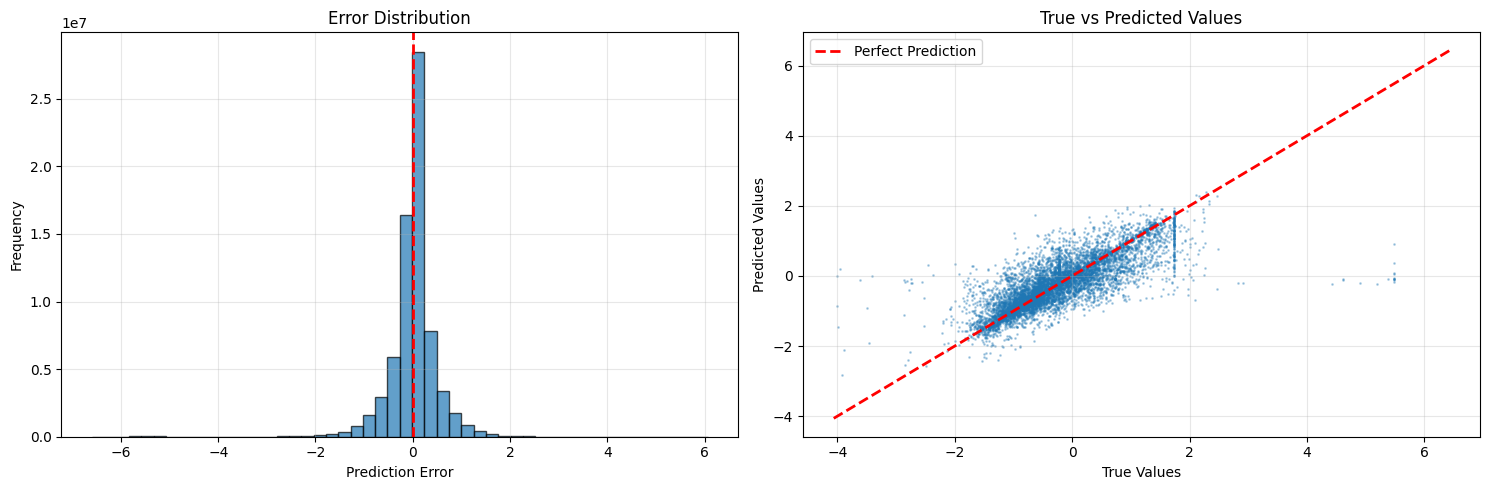

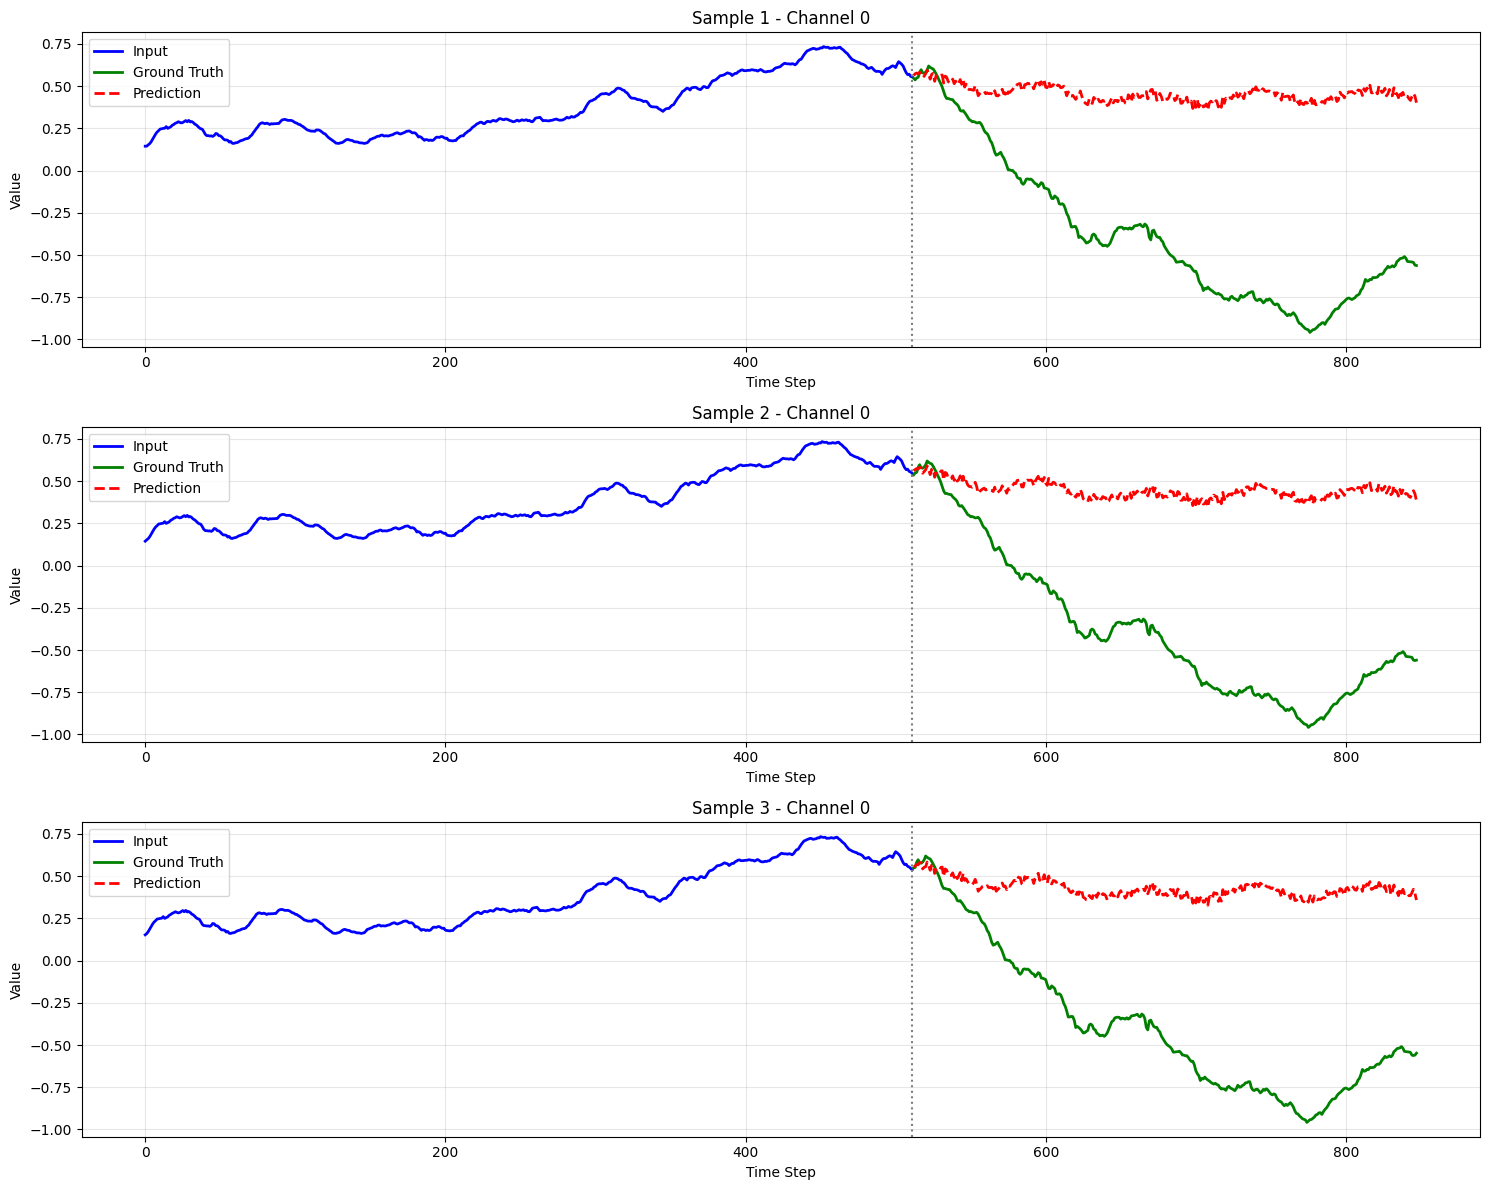

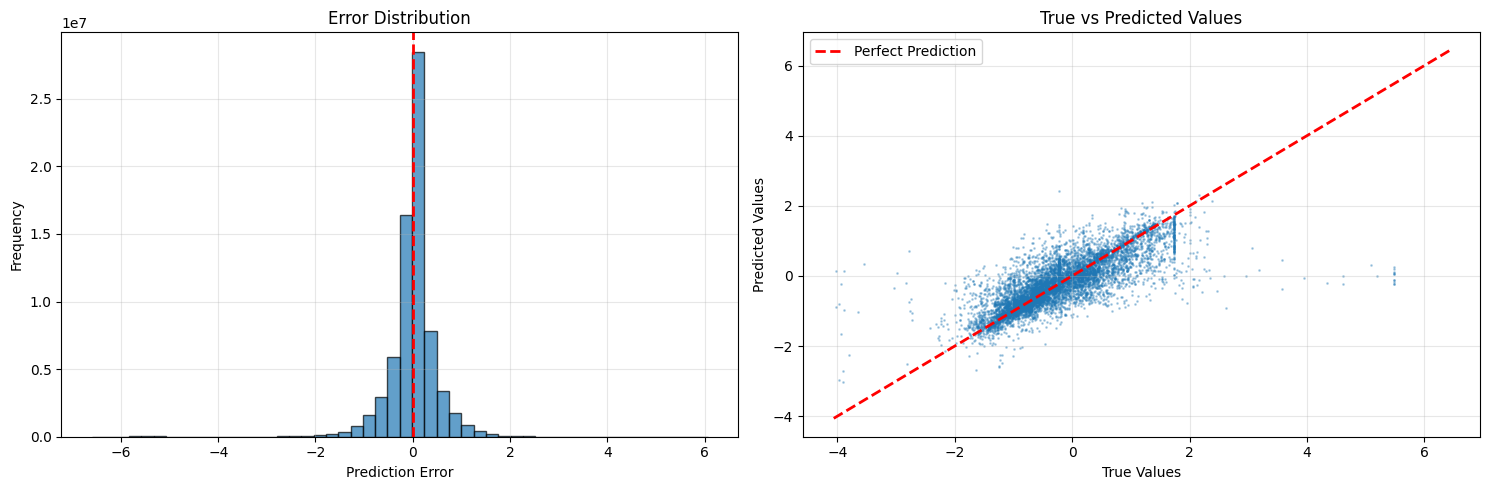

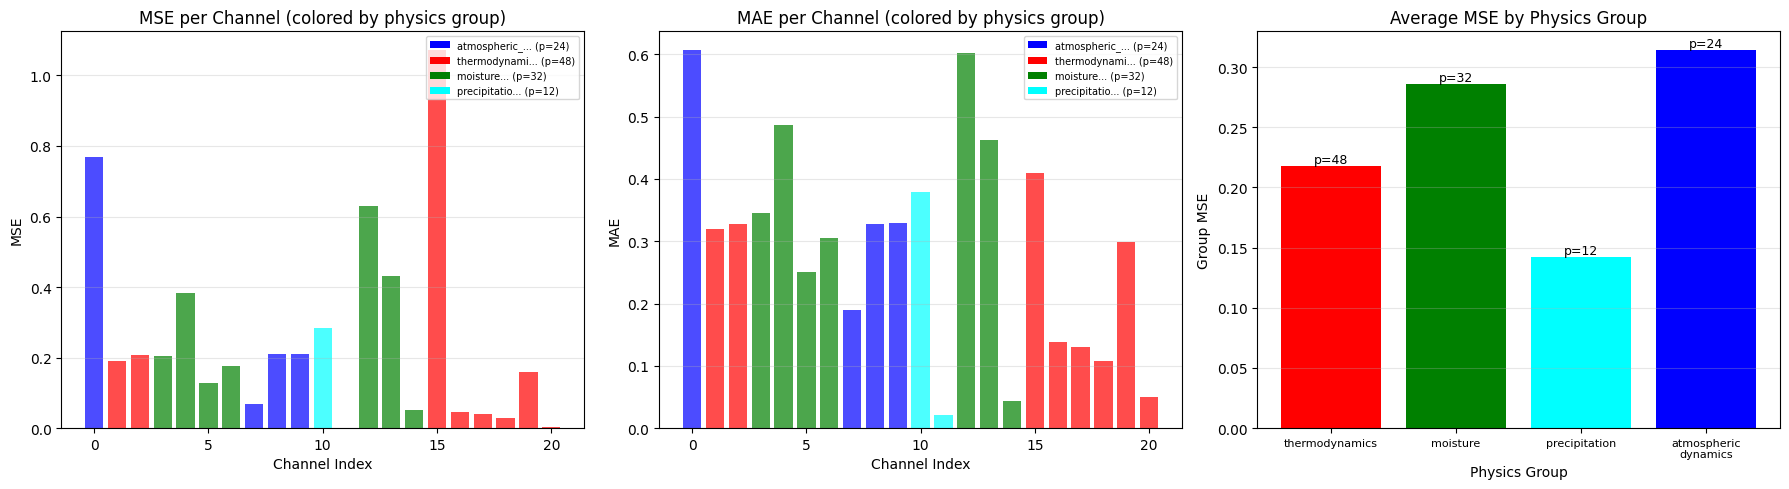

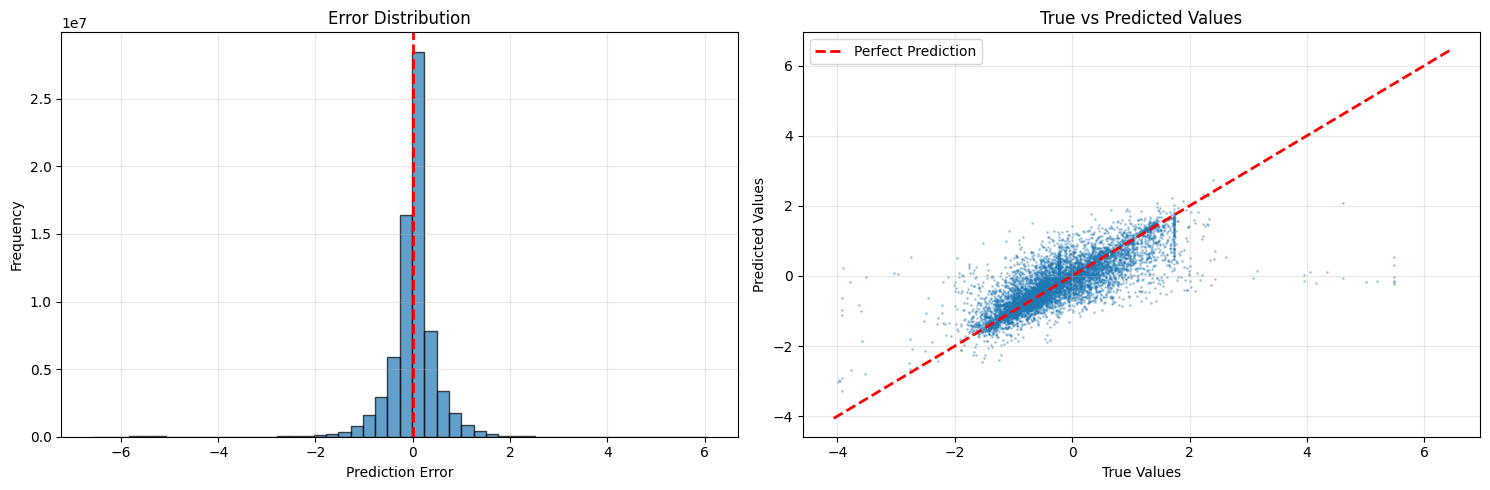

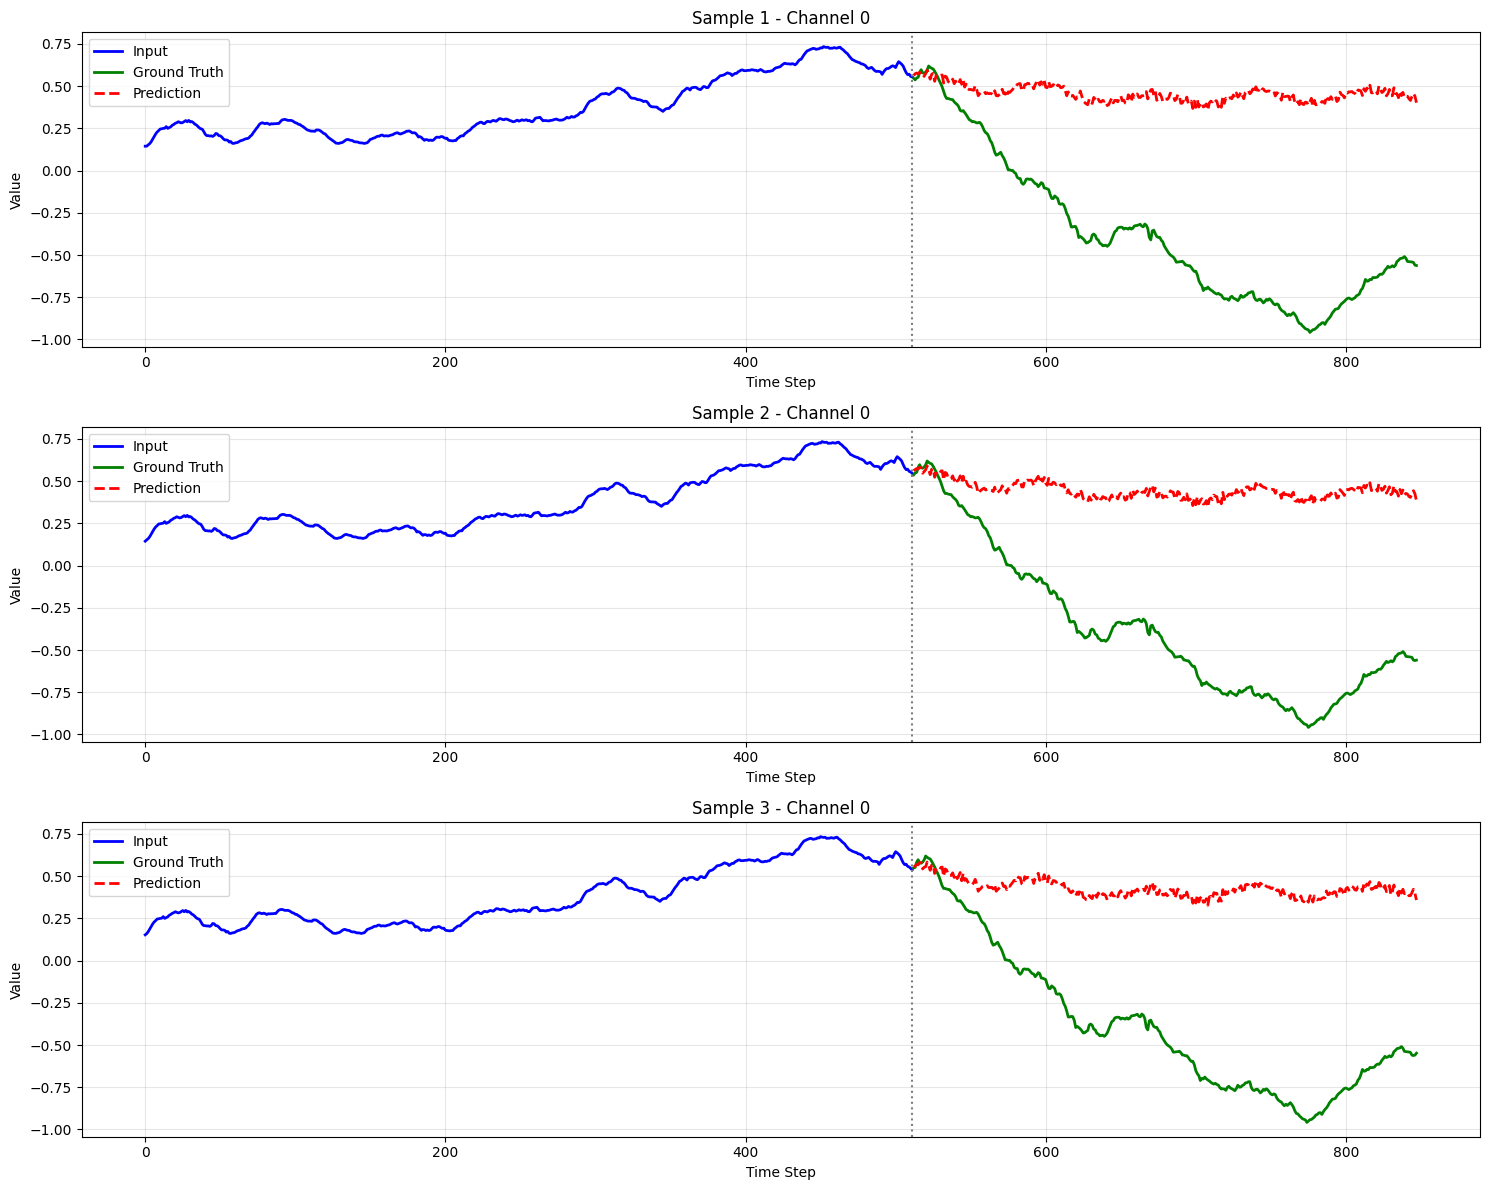

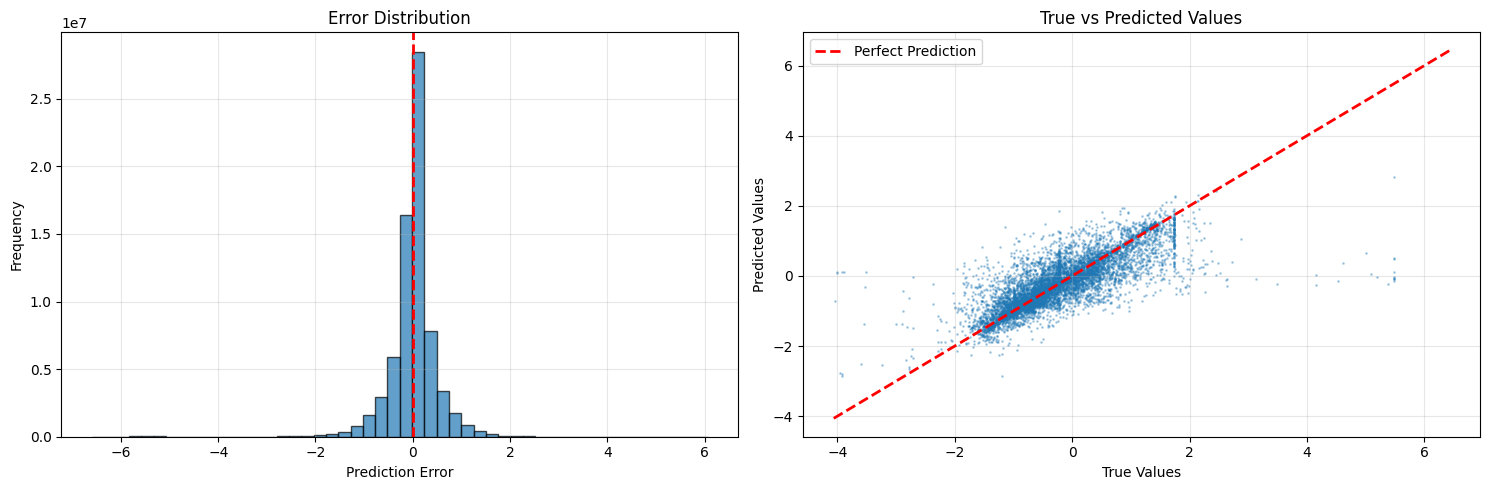

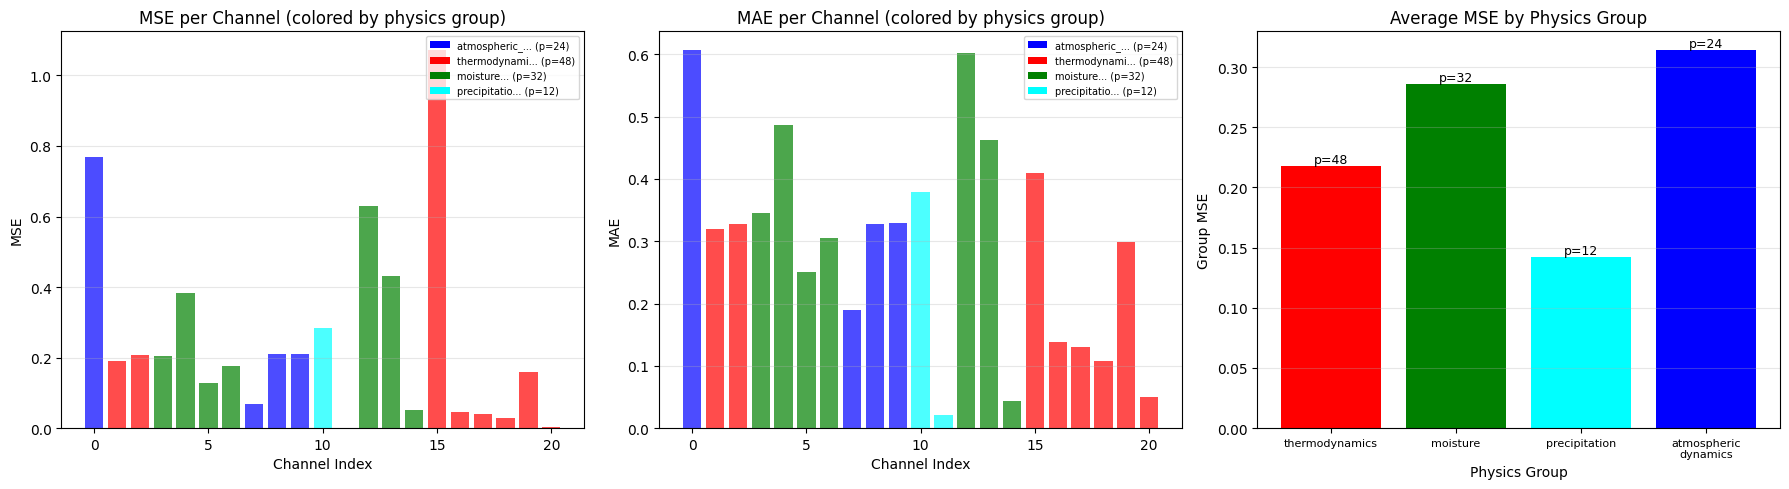

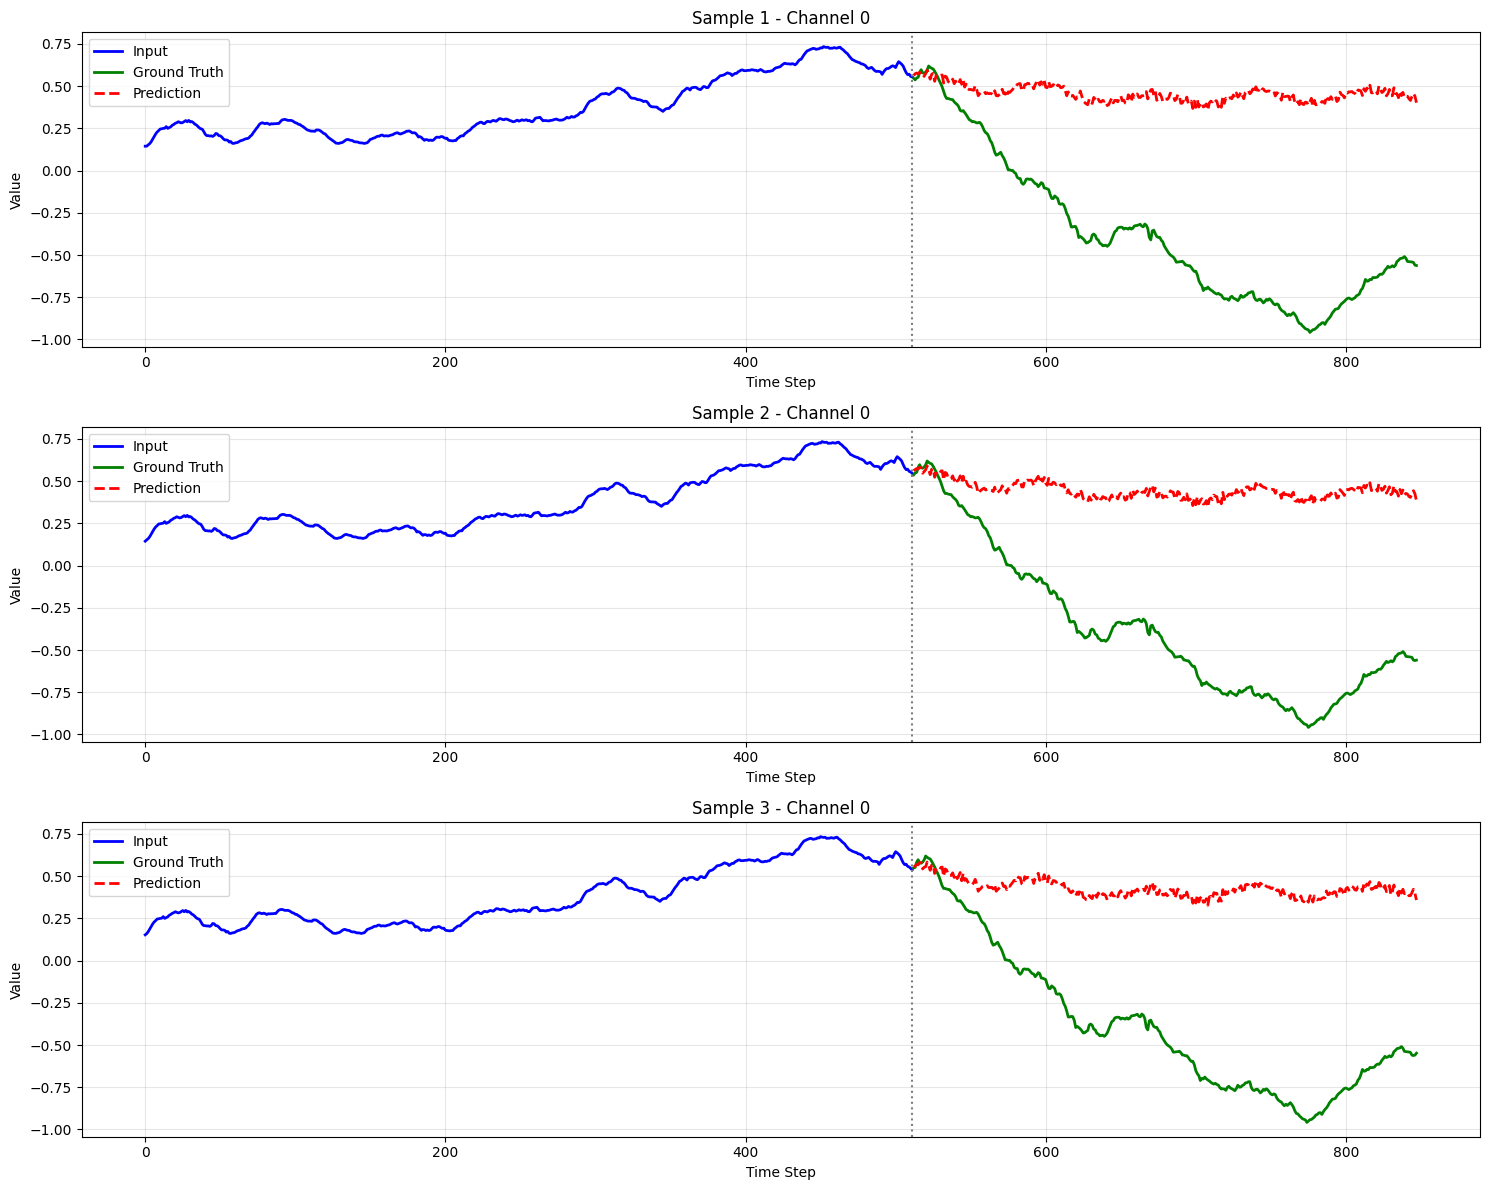

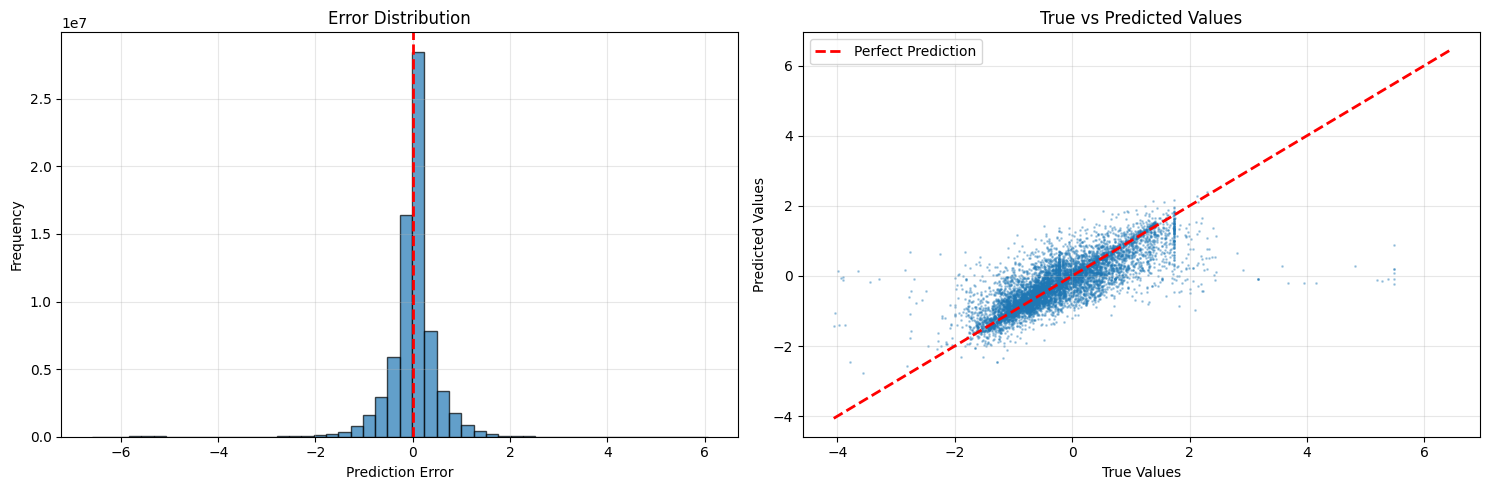

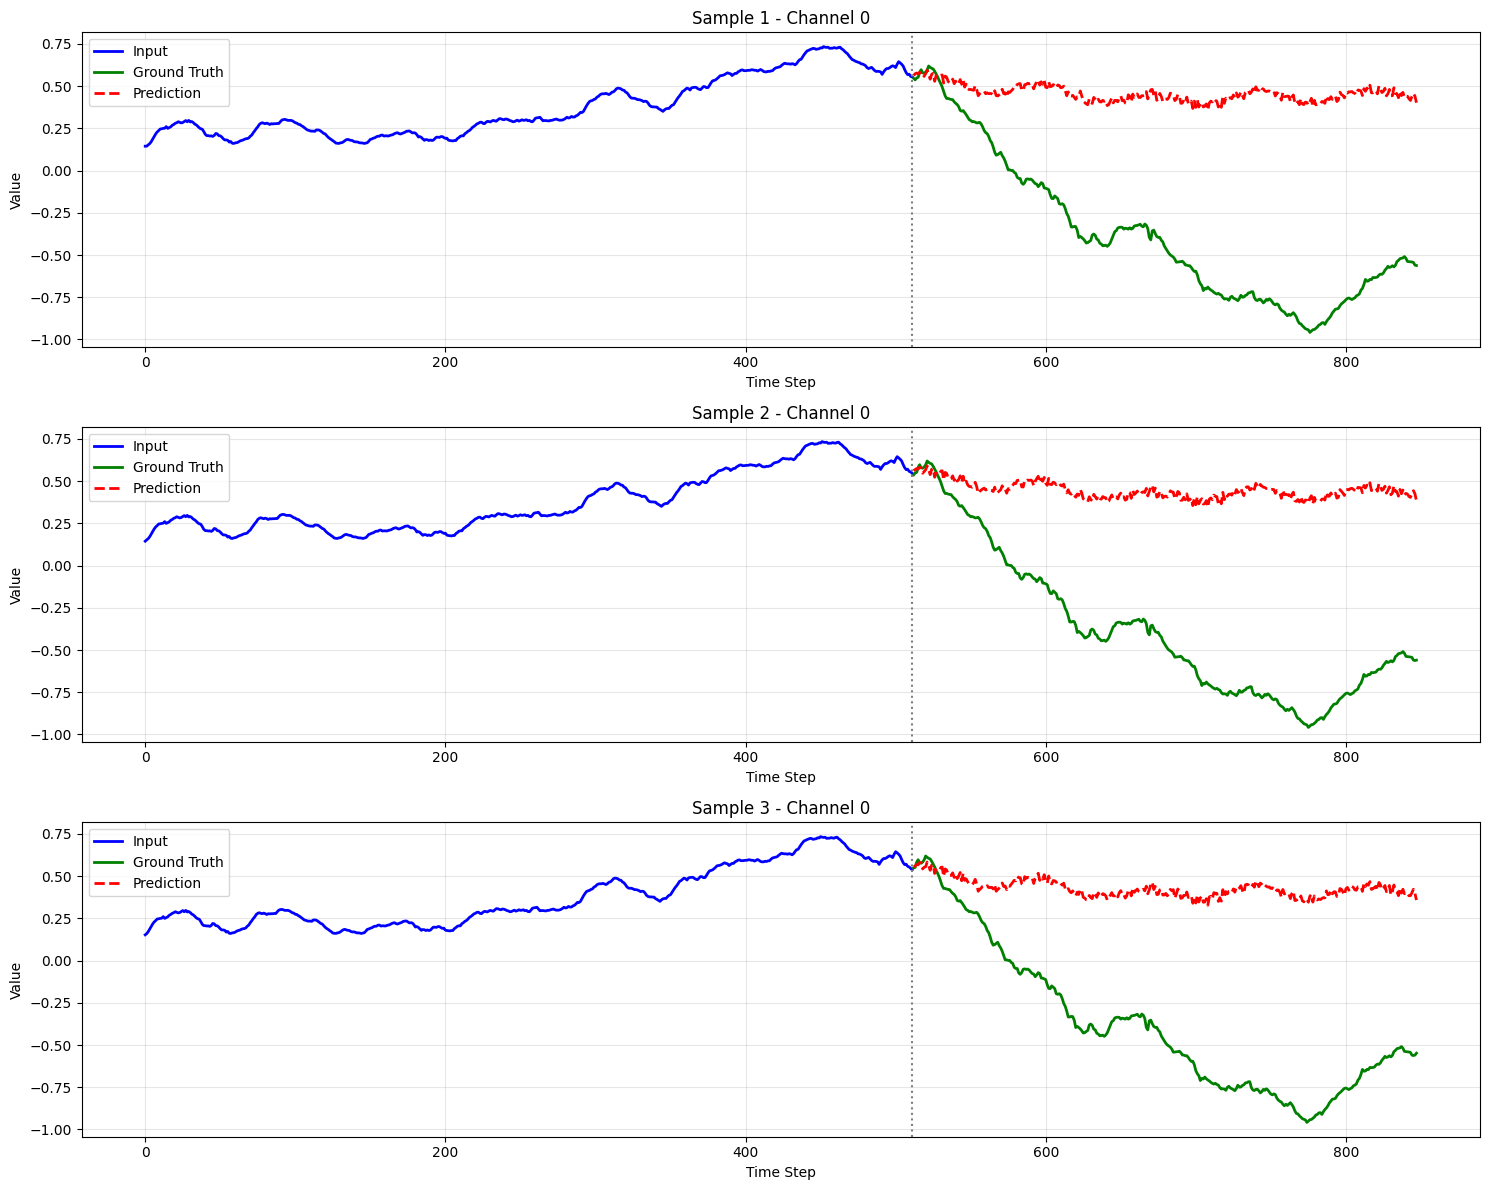

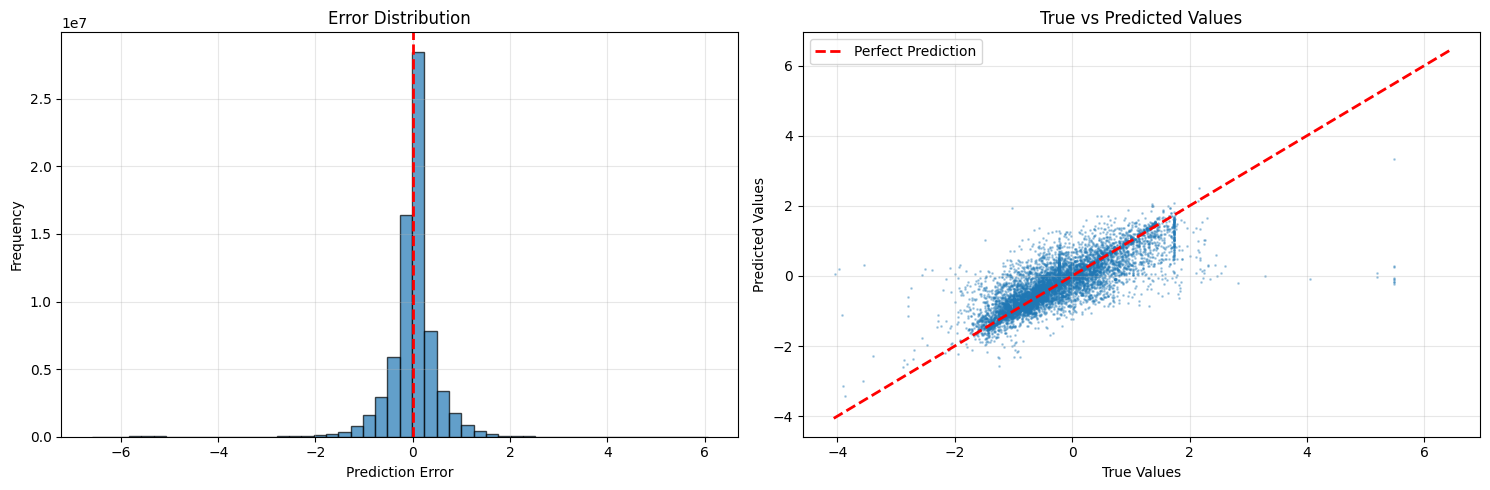

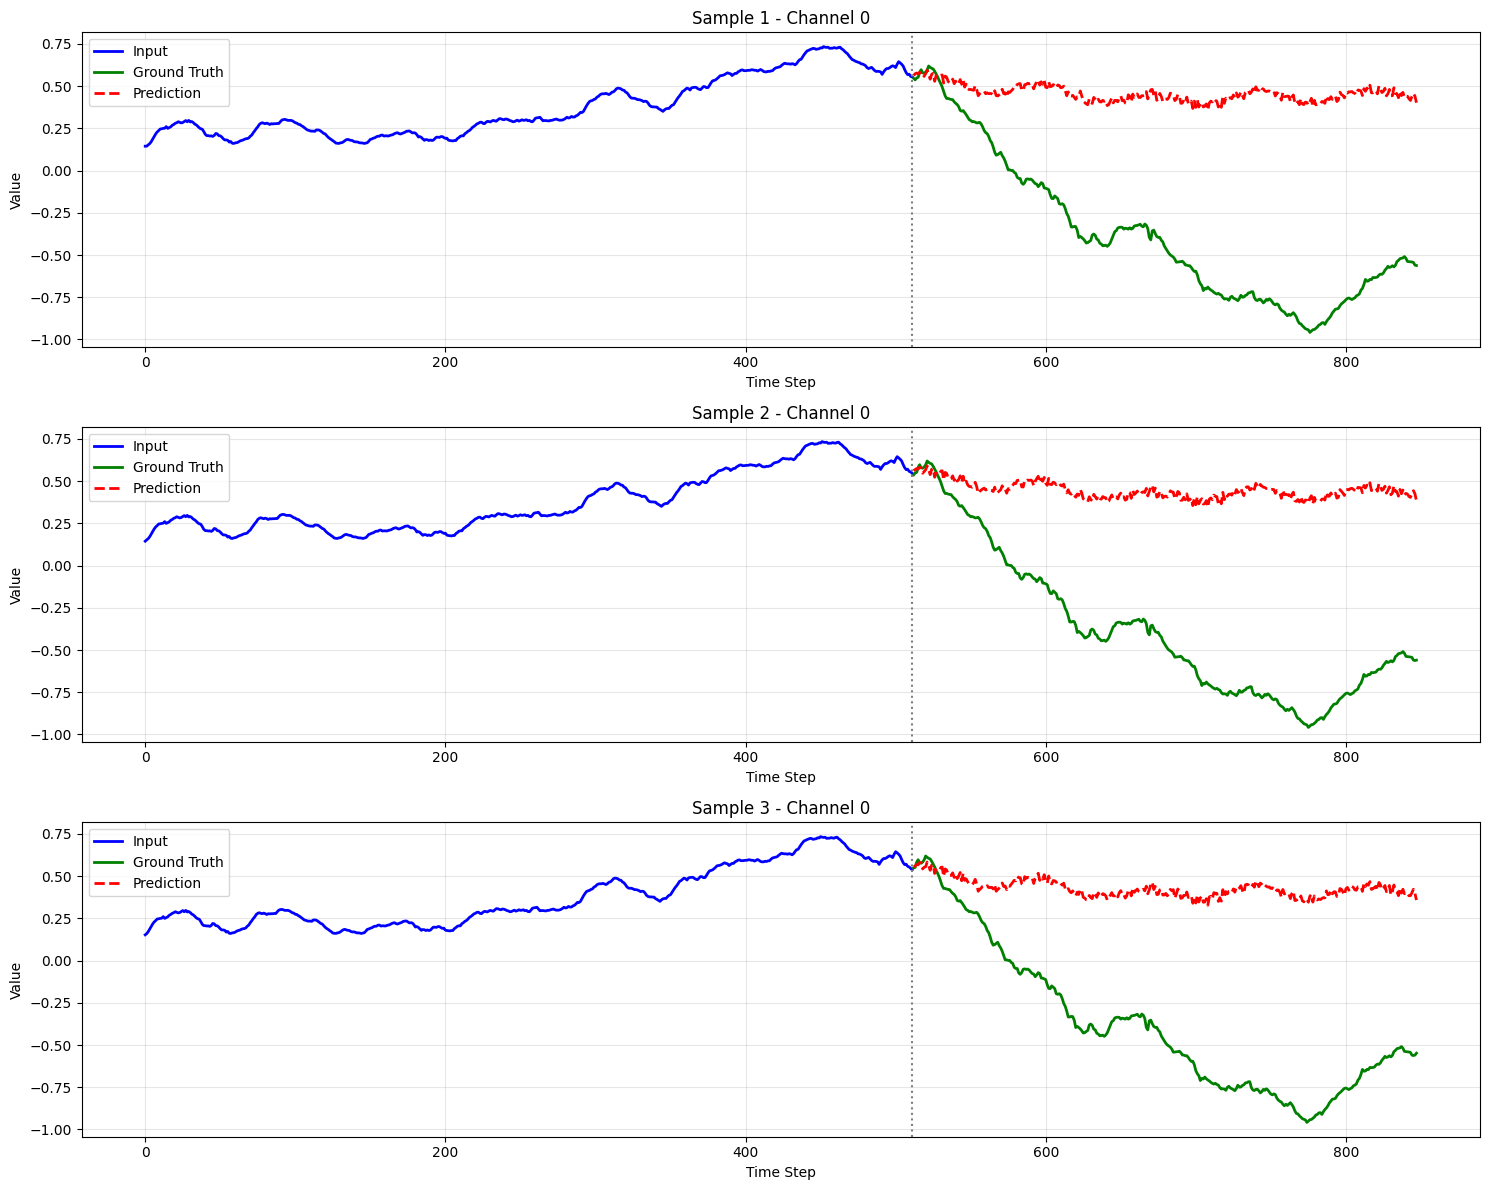

In [47]:
# Visualize predictions
%matplotlib inline

def plot_predictions(inputs, trues, preds, num_samples=3, channel_idx=0):
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Concatenate input and prediction/ground truth
        input_seq = inputs[i, :, channel_idx]
        true_seq = trues[i, :, channel_idx]
        pred_seq = preds[i, :, channel_idx]
        
        # Time steps
        input_steps = np.arange(len(input_seq))
        pred_steps = np.arange(len(input_seq), len(input_seq) + len(pred_seq))
        
        # Plot
        axes[i].plot(input_steps, input_seq, 'b-', label='Input', linewidth=2)
        axes[i].plot(pred_steps, true_seq, 'g-', label='Ground Truth', linewidth=2)
        axes[i].plot(pred_steps, pred_seq, 'r--', label='Prediction', linewidth=2)
        axes[i].axvline(x=len(input_seq)-1, color='gray', linestyle=':', linewidth=1.5)
        axes[i].set_title(f'Sample {i+1} - Channel {channel_idx}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot sample predictions
print(f"preds shape: {preds.shape}, trues shape: {trues.shape}, inputs shape: {inputs.shape}")
fig = plot_predictions(inputs, trues, preds, num_samples=3, channel_idx=0)
plt.show()

Error stats - mean: 0.008426, std: 0.501806


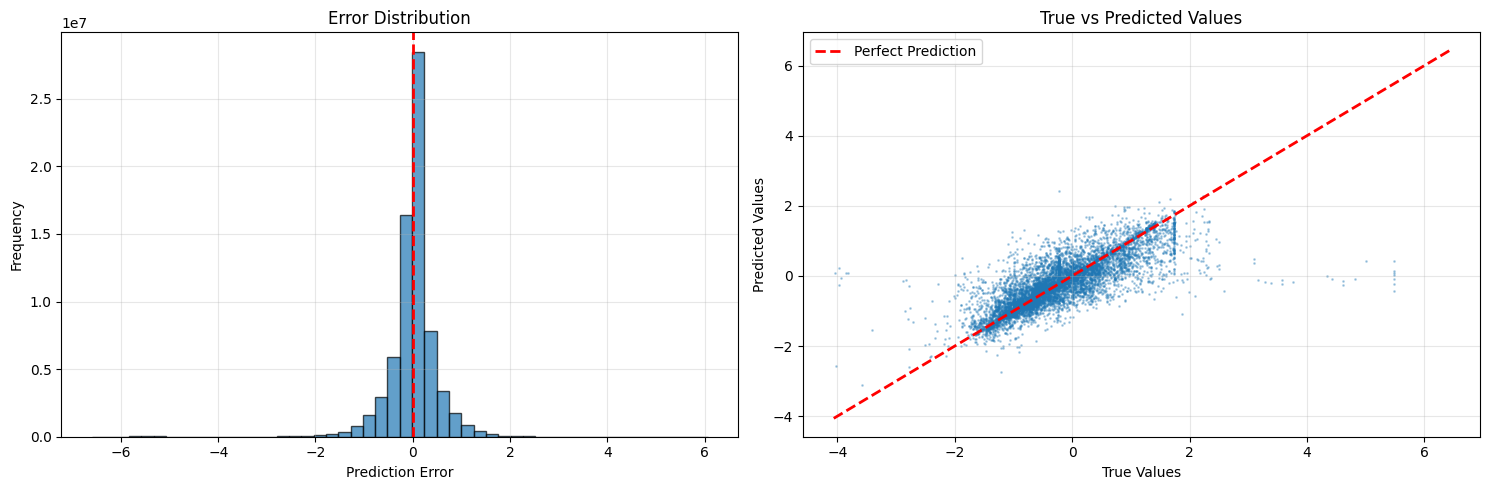

In [48]:
# Plot prediction error distribution
%matplotlib inline

errors = preds - trues
print(f"Error stats - mean: {errors.mean():.6f}, std: {errors.std():.6f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error distribution
axes[0].hist(errors.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

# Scatter plot: True vs Predicted
sample_size = min(10000, preds.size)
idx = np.random.choice(preds.size, sample_size, replace=False)
axes[1].scatter(trues.flatten()[idx], preds.flatten()[idx], alpha=0.3, s=1)

# Add perfect prediction line
min_val = min(trues.flatten().min(), preds.flatten().min())
max_val = max(trues.flatten().max(), preds.flatten().max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_xlabel('True Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('True vs Predicted Values')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Per-Channel Performance (Physics-Based Grouping - Weather Only):

THERMODYNAMICS GROUP (patch=48) (+hour integrated):
Channel  Name                      MSE          MAE          RMSE        
---------------------------------------------------------------------------
1        T (degC)                  0.1909269    0.3189944    0.4369518   
2        Tpot (K)                  0.2069113    0.3279855    0.4548750   
15       Tdew (degC)               1.0715134    0.4093655    1.0351393   
16       Tlog (degC)               0.0454746    0.1375090    0.2132477   
17       CO2 (ppm)                 0.0397648    0.1294671    0.1994111   
18       PAR (μmol/m²/s)           0.0290459    0.1081678    0.1704285   
19       Tmax (degC)               0.1577425    0.2989773    0.3971681   
20       Tmin (degC)               0.0035719    0.0501896    0.0597655   

MOISTURE GROUP (patch=32) (+hour integrated):
Channel  Name                      MSE          MAE          RMSE        
------------------

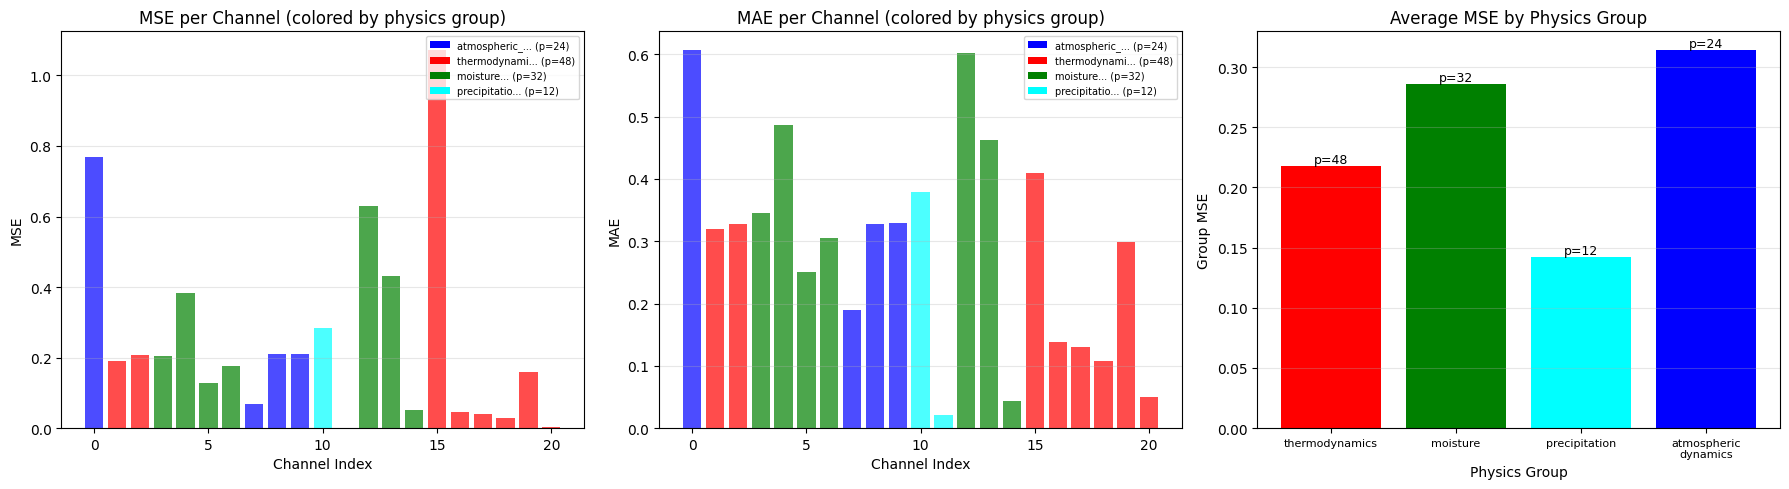


Plot displayed above.


In [ ]:
# Per-channel performance analysis (ordered by channel index, like PatchTST_Original)
%matplotlib inline

num_channels = preds.shape[-1]  # 21 weather channels
channel_metrics = []

# Channel names from WEATHER_CHANNELS (ordered 0-20)
channel_names = [
    'p (mbar)', 'T (degC)', 'Tpot (K)', 'rh (%)', 'VPmax (mbar)', 
    'VPact (mbar)', 'VPdef (mbar)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)',
    'rain (mm)', 'raining (s)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)',
    'Tdew (degC)', 'Tlog (degC)', 'CO2 (ppm)', 'PAR (μmol/m²/s)', 'Tmax (degC)', 'Tmin (degC)'
]

print("\nPer-Channel Performance:")
print("=" * 80)
print(f"{'Channel':<10} {'Name':<20} {'MSE':<15} {'MAE':<15} {'RMSE':<15}")
print("=" * 80)

for ch in range(num_channels):
    ch_pred = preds[:, :, ch]
    ch_true = trues[:, :, ch]
    
    ch_mse = np.mean((ch_pred - ch_true) ** 2)
    ch_mae = np.mean(np.abs(ch_pred - ch_true))
    ch_rmse = np.sqrt(ch_mse)
    
    ch_name = channel_names[ch] if ch < len(channel_names) else f'Ch{ch}'
    channel_metrics.append({'channel': ch, 'name': ch_name, 'mse': ch_mse, 'mae': ch_mae, 'rmse': ch_rmse})
    print(f"{ch:<10} {ch_name:<20} {ch_mse:<15.7f} {ch_mae:<15.7f} {ch_rmse:<15.7f}")

print("=" * 80)

# Visualize channel performance
channels = [m['channel'] for m in channel_metrics]
mses = [m['mse'] for m in channel_metrics]
maes = [m['mae'] for m in channel_metrics]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(channels, mses)
axes[0].set_xlabel('Channel')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE per Channel')
axes[0].grid(True, alpha=0.3)

axes[1].bar(channels, maes)
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE per Channel')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Advanced: Custom Channel Groupings <a id='advanced'></a>

Experiment with different channel groupings and patch lengths based on domain knowledge.

In [37]:
# Analyze Physics-Based Patch Length Selection
print("Physics-Based Patch Length Analysis for Weather Variables")
print("=" * 70)

# Show physics reasoning for each group
reasoning = {
    'atmospheric_dynamics': """
    ATMOSPHERIC DYNAMICS (Pressure, Wind):
    - Pressure gradients drive wind through geostrophic balance
    - Synoptic-scale weather systems evolve over hours
    - 24-step patches (~4 hours) capture pressure wave propagation
    - Wind responds to pressure changes with some lag
    """,
    'thermodynamics': """
    THERMODYNAMICS (Temperature, CO2, PAR):
    - Temperature follows diurnal (daily) solar cycle
    - CO2 correlates with temperature through photosynthesis
    - PAR (solar radiation) drives the daily temperature pattern
    - 48-step patches (~8 hours) capture half the diurnal cycle
    """,
    'moisture': """
    MOISTURE (Humidity, Vapor Pressure):
    - Evaporation/condensation processes operate on intermediate scales
    - Humidity responds to both temperature and wind advection
    - 32-step patches (~5.3 hours) balance these time scales
    - Captures moisture transport by weather systems
    """,
    'precipitation': """
    PRECIPITATION (Rain):
    - Convective events are fast and episodic
    - Rain showers typically last 30 min to 2 hours
    - 12-step patches (~2 hours) capture individual events
    - Longer patches would smooth out precipitation signals
    """,
    'temporal': """
    TEMPORAL (Hour-of-Day):
    - Cyclical encoding of the 24-hour period
    - Same scale as thermodynamics (diurnal)
    - 48-step patches align with temperature patterns
    - Helps model learn time-dependent weather patterns
    """
}

for group_name, text in reasoning.items():
    print(f"\n{group_name.upper()}:")
    print(text)

# Calculate effective receptive fields
print("\n" + "=" * 70)
print("Effective Receptive Fields (Physics-Based Grouping):")
print("=" * 70)
for group_name, cfg in args.patch_configs.items():
    patch_len = cfg['patch_len']
    stride = cfg['stride']
    n_patches = int((args.seq_len - patch_len) / stride + 1) + 1  # +1 for padding
    receptive_field = n_patches * stride + (patch_len - stride)
    n_channels = len(args.channel_groups[group_name]['indices'])
    
    print(f"\n{group_name} ({n_channels} channels):")
    print(f"  Patch length: {patch_len} steps ({patch_len * 10} min = {patch_len * 10 / 60:.1f} hours)")
    print(f"  Stride: {stride} steps ({stride * 10} min)")
    print(f"  Number of patches: {n_patches}")
    print(f"  Effective receptive field: {receptive_field} steps ({receptive_field * 10 / 60:.1f} hours)")
print("=" * 70)

Physics-Based Patch Length Analysis for Weather Variables

ATMOSPHERIC_DYNAMICS:

    ATMOSPHERIC DYNAMICS (Pressure, Wind):
    - Pressure gradients drive wind through geostrophic balance
    - Synoptic-scale weather systems evolve over hours
    - 24-step patches (~4 hours) capture pressure wave propagation
    - Wind responds to pressure changes with some lag
    

THERMODYNAMICS:

    THERMODYNAMICS (Temperature, CO2, PAR):
    - Temperature follows diurnal (daily) solar cycle
    - CO2 correlates with temperature through photosynthesis
    - PAR (solar radiation) drives the daily temperature pattern
    - 48-step patches (~8 hours) capture half the diurnal cycle
    

MOISTURE:

    MOISTURE (Humidity, Vapor Pressure):
    - Evaporation/condensation processes operate on intermediate scales
    - Humidity responds to both temperature and wind advection
    - 32-step patches (~5.3 hours) balance these time scales
    - Captures moisture transport by weather systems
    

PRECIPITATI

In [ ]:
# Create alternative channel groupings for experimentation

# Alternative 1: More granular grouping (5 groups)
WEATHER_CHANNELS_V2 = {
    'very_fast': {
        'indices': [7, 8],  # Wind speed only
        'names': ['wv (m/s)', 'max. wv (m/s)'],
        'patch_len': 8,
        'stride': 4,
    },
    'fast': {
        'indices': [9, 10, 11],  # Wind direction, precipitation
        'names': ['wd (deg)', 'rain (mm)', 'raining (s)'],
        'patch_len': 16,
        'stride': 8,
    },
    'medium': {
        'indices': [3, 4, 5, 6],  # Humidity-related
        'names': ['rh (%)', 'VPmax', 'VPact', 'VPdef'],
        'patch_len': 24,
        'stride': 12,
    },
    'slow': {
        'indices': [0, 12, 13, 14],  # Pressure, concentration
        'names': ['p (mbar)', 'sh', 'H2OC', 'rho'],
        'patch_len': 36,
        'stride': 18,
    },
    'very_slow': {
        'indices': [1, 2, 15, 16, 17, 18, 19, 20],  # Temperature-related
        'names': ['T (degC)', 'Tpot', 'Tdew', 'Tlog', 'CO2', 'PAR', 'Tmax', 'Tmin'],
        'patch_len': 48,
        'stride': 24,
    }
}

print("Alternative Channel Grouping (5 groups - more granular):")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS_V2.items():
    print(f"\n{group_name}:")
    print(f"  Channels: {group_info['indices']}")
    print(f"  Patch: {group_info['patch_len']} steps, Stride: {group_info['stride']} steps")

# Alternative 2: Physics-based grouping
WEATHER_CHANNELS_PHYSICS = {
    'atmospheric_dynamics': {
        'indices': [0, 7, 8, 9],  # Pressure, wind
        'names': ['p (mbar)', 'wv', 'max wv', 'wd'],
        'patch_len': 24,  # Synoptic scale
        'stride': 12,
    },
    'thermodynamics': {
        'indices': [1, 2, 15, 16, 18, 19, 20],  # All temperature
        'names': ['T', 'Tpot', 'Tdew', 'Tlog', 'Tmax', 'Tmin', 'CO2'],
        'patch_len': 48,  # Diurnal cycle
        'stride': 24,
    },
    'moisture': {
        'indices': [3, 4, 5, 6, 12, 13, 14],  # Humidity, vapor
        'names': ['rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho'],
        'patch_len': 32,  # Moisture transport
        'stride': 16,
    },
    'precipitation': {
        'indices': [10, 11, 17],  # Rain, radiation
        'names': ['rain', 'raining', 'PAR'],
        'patch_len': 12,  # Convective events
        'stride': 6,
    }
}

print("\n\nPhysics-Based Channel Grouping:")
print("=" * 70)
for group_name, group_info in WEATHER_CHANNELS_PHYSICS.items():
    print(f"\n{group_name}:")
    print(f"  Channels: {group_info['indices']}")
    print(f"  Physical reasoning: Related variables grouped together")
    print(f"  Patch: {group_info['patch_len']} steps ({group_info['patch_len']*10/60:.1f} hours)")
print("=" * 70)

In [ ]:
# Benchmark: Variable-Length vs Fixed-Length comparison
print("\nModel Comparison: Variable-Length vs Fixed-Length PatchTST")
print("=" * 70)

# Variable-length model (already created)
vl_total, vl_trainable = count_parameters(model)

# Create fixed-length baseline for comparison
class FixedLengthBaseline(nn.Module):
    """Fixed patch length baseline (original PatchTST style)"""
    def __init__(self, configs, patch_len=16, stride=8):
        super().__init__()
        self.enc_in = configs.enc_in
        self.pred_len = configs.pred_len
        
        self.encoder = PerChannelEncoder(
            n_channels=configs.enc_in,
            context_window=configs.seq_len,
            target_window=configs.pred_len,
            patch_len=patch_len,
            stride=stride,
            n_layers=configs.e_layers,
            d_model=configs.d_model,
            n_heads=configs.n_heads,
            d_ff=configs.d_ff,
            dropout=configs.dropout,
            head_dropout=configs.head_dropout
        )
        
        self.revin = configs.revin
        if self.revin:
            self.revin_layer = RevIN(configs.enc_in, affine=configs.affine, 
                                      subtract_last=configs.subtract_last)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [bs, enc_in, seq_len]
        
        if self.revin:
            x = x.permute(0, 2, 1)
            x = self.revin_layer(x, 'norm')
            x = x.permute(0, 2, 1)
        
        output = self.encoder(x)  # [bs, enc_in, pred_len]
        output = output.permute(0, 2, 1)  # [bs, pred_len, enc_in]
        
        if self.revin:
            output = self.revin_layer(output, 'denorm')
        
        return output

# Create baseline model
baseline_model = FixedLengthBaseline(args, patch_len=16, stride=8).float().to(device)
bl_total, bl_trainable = count_parameters(baseline_model)

# Compare
print(f"\n{'Model':<30} {'Parameters':>15} {'Size (MB)':>12}")
print("-" * 60)
print(f"{'Fixed-Length (patch=16)':<30} {bl_total:>15,} {bl_total * 4 / 1024 / 1024:>12.2f}")
print(f"{'Variable-Length (12/24/48)':<30} {vl_total:>15,} {vl_total * 4 / 1024 / 1024:>12.2f}")
print(f"{'Difference':<30} {vl_total - bl_total:>+15,} {(vl_total - bl_total) * 4 / 1024 / 1024:>+12.2f}")

# Inference speed comparison
input_shape = (args.batch_size, args.seq_len, args.enc_in)

print(f"\nInference Speed (batch_size={args.batch_size}):")
print("-" * 60)

for name, m in [("Fixed-Length", baseline_model), ("Variable-Length", model)]:
    avg_time = benchmark_model(m, input_shape, num_runs=50)
    print(f"{name:<30}: {avg_time:.2f} ms/batch")

print("=" * 70)

## Summary: Physics-Integrated Hour-of-Day PatchTST

This notebook implemented **Physics-Integrated PatchTST** where hour-of-day features are **embedded directly into physics groups** rather than kept separate.

### Key Innovation: Integrated Hour Features

Instead of treating hour_sin/hour_cos as a separate channel group, we **integrate them into physics groups** that have strong diurnal dependence:

| Group | Physics Channels | Hour Features | Why Integrate? |
|-------|-----------------|---------------|----------------|
| **Thermodynamics** | 8 (temp, CO2, PAR) | ✓ hour_sin/cos | Solar cycle drives temperature |
| **Moisture** | 7 (humidity, vapor) | ✓ hour_sin/cos | Day evaporation / night condensation |
| **Precipitation** | 2 (rain) | ✓ hour_sin/cos | Afternoon convective storms |
| **Atmos. Dynamics** | 4 (pressure, wind) | ✗ | Synoptic-dominated, weak diurnal |

### Architecture Benefits:

1. **Direct Hour-Physics Learning**: Each encoder learns the correlation between time-of-day and its physics variables at the appropriate temporal resolution
   - Thermodynamics: 48-step patches capture the diurnal solar heating cycle
   - Moisture: 32-step patches capture day/night evaporation patterns
   - Precipitation: 12-step patches capture afternoon storm timing

2. **Input vs Output Separation**:
   - **Input**: 23 channels (21 weather + hour_sin + hour_cos)
   - **Output**: 21 channels (weather only - hour features are deterministic)

3. **Physics-Appropriate Patch Lengths**:
   - Hour features are processed at the SAME patch length as their physics group
   - Temperature + hour at 48 steps → learns "temperature rises after sunrise"
   - Rain + hour at 12 steps → learns "convection peaks at 15:00"

### Comparison with Separate Hour Group:

| Approach | Hour Processing | Learning |
|----------|----------------|----------|
| **Separate Group** | One encoder for hour features | Hour patterns learned independently |
| **Integrated (this)** | Hour in each physics encoder | Direct hour-physics correlations |

### Physics Rationale:

```
Temperature(t) = f(solar_radiation(hour), ...) 
                 ↑ Hour features help predict this

Humidity(t) = g(evaporation(hour), temperature, ...)
              ↑ Daytime evaporation, nighttime condensation

Rain(t) = h(convection(hour), moisture, ...)
          ↑ Afternoon convective instability
```

### Configuration Summary:

| Group | Input Ch | Output Ch | Patch Length | Physics Scale |
|-------|----------|-----------|--------------|---------------|
| Thermodynamics | 10 | 8 | 48 (~8h) | Diurnal |
| Moisture | 9 | 7 | 32 (~5.3h) | Evaporation |
| Precipitation | 4 | 2 | 12 (~2h) | Convective |
| Atmos. Dynamics | 4 | 4 | 24 (~4h) | Synoptic |

### Next Steps:
- Compare with separate hour group approach
- Add cross-group attention for physically coupled variables
- Learn optimal hour-feature weighting per group
- Add seasonal features (day-of-year) for annual cycles

### References:
- PatchTST Paper: https://arxiv.org/abs/2211.14730
- This enhancement: Physics-integrated hour-of-day features